In [1]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 13.9 MB/s eta 0:00:00


In [ ]:
# STEP 1: Import Libraries
# ================================
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

# ================================
# STEP 2: Load Excel File
# ================================
df = pd.read_excel("/content/2020-2025_interpolated.xlsx")  # แก้เป็น .csv ถ้าเป็น CSV

# ================================
# STEP 3: Prepare Data
# ================================
df['Date'] = pd.to_datetime(df['Date'])
df = df[~df.duplicated(['Date','Symbol'], keep='first')]
df = df.sort_values(['Symbol','Date'])

In [ ]:
df

,Date,Symbol,Close,Volume,Stock Name,Sector,holiday,weekend,pre_holiday,post_holiday,day_of_year,day_of_week
0,2020-01-01,AAPL,72.538521,NaN,Apple Inc.,Information Technology,1,0,0,0,1,2
1,2020-01-02,AAPL,72.538521,135480400.0,Apple Inc.,Information Technology,0,0,0,1,2,3
2,2020-01-03,AAPL,71.833282,146322800.0,Apple Inc.,Information Technology,0,0,1,0,3,4
3,2020-01-04,AAPL,151.815147,NaN,Apple Inc.,Information Technology,1,1,1,0,4,5
4,2020-01-05,AAPL,150.521988,NaN,Apple Inc.,Information Technology,1,1,0,1,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...
259681,2025-08-18,ZBRA,317.480011,360200.0,Zebra Technologies Corporation,Information Technology,0,0,0,1,230,0
259682,2025-08-19,ZBRA,312.059998,542800.0,Zebra Technologies Corporation,Information Technology,0,0,0,0,231,1
259683,2025-08-20,ZBRA,304.739990,652100.0,Zebra Technologies Corporation,Information Technology,0,0,0,0,232,2
259684,2025-08-21,ZBRA,308.510010,392800.0,Zebra Technologies Corporation,Information Technology,0,0,0,0,233,3


In [ ]:
# ================================
# Multi-stock decomposition + Volume Imputation
# ================================
all_stocks = []

for symbol, group in df.groupby('Symbol'):
    temp_df = group.copy()
    temp_df = temp_df.set_index('Date').sort_index()
    temp_df = temp_df[['Close', 'Volume']].asfreq("B")  # เติม NaN วันหยุด

    # ================================
    # เติมค่า Close ด้วย interpolation + ffill/bfill
    # ================================
    temp_df['Close_filled'] = temp_df['Close'].interpolate(method='time')
    temp_df['Close_filled'] = temp_df['Close_filled'].fillna(method='bfill').fillna(method='ffill')

    # ================================
    # เติมค่า Volume
    # ================================
    # วิธีง่าย: เติมด้วย mean ของหุ้นนั้น
    mean_volume = temp_df['Volume'].mean()


    # ถ้าต้องการใช้วิธีอื่น เช่น forward/backward fill
    temp_df['Volume_filled'] = temp_df['Volume'].fillna(method='ffill').fillna(method='bfill')

    # ================================
    # Seasonal decomposition
    # ================================
    result = seasonal_decompose(temp_df['Close_filled'], model='additive', period=5, extrapolate_trend='freq')

    # ================================
    # สร้าง DataFrame ของหุ้นนั้น
    # ================================
    decomposed_df = pd.DataFrame({
        'Symbol': symbol,
        'Observed': result.observed,
        'Trend': result.trend,
        'Seasonal': result.seasonal,
        'Residual': result.resid,
        'Close_filled': temp_df['Close_filled'],
        'Volume_filled': temp_df['Volume_filled']
    }, index=temp_df.index)

    all_stocks.append(decomposed_df)

# รวมทุกหุ้น
final_df = pd.concat(all_stocks).reset_index().rename(columns={'index':'Date'})


/tmp/ipython-input-130727173.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df['Close_filled'] = temp_df['Close_filled'].fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-130727173.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df['Volume_filled'] = temp_df['Volume'].fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-130727173.py:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df['Close_filled'] = temp_df['Close_filled'].fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-130727173.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp_df['Volume_filled'] = temp_d

In [ ]:
final_df.to_excel("final_df.xlsx", index=False)

In [6]:
# STEP 1: Import Libraries
# ================================
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal

# ================================
# STEP 2: Load Excel File
# ================================
df = pd.read_excel("/content/final_df.xlsx")  # แก้เป็น .csv ถ้าเป็น CSV

In [7]:
df

,Date,Symbol,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled
0,2020-01-01,AAPL,72.538521,71.011472,-0.322403,1.849453,72.538521,135480400
1,2020-01-02,AAPL,72.538521,71.526089,-0.950289,1.962721,72.538521,135480400
2,2020-01-03,AAPL,71.833282,72.276231,0.569353,-1.012302,71.833282,146322800
3,2020-01-06,AAPL,72.405678,72.413409,0.566151,-0.573883,72.405678,118387200
4,2020-01-07,AAPL,72.065155,72.861658,0.137189,-0.933691,72.065155,108872000
...,...,...,...,...,...,...,...,...
185593,2025-08-18,ZBRA,317.480011,315.977997,0.744131,0.757883,317.480011,360200
185594,2025-08-19,ZBRA,312.059998,312.138000,0.257691,-0.335694,312.059998,542800
185595,2025-08-20,ZBRA,304.739990,313.116003,-0.163171,-8.212842,304.739990,652100
185596,2025-08-21,ZBRA,308.510010,306.201598,-0.355500,2.663912,308.510010,392800


In [8]:
df.describe()

,Date,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled
count,185598,185598.000000,185598.000000,185598.000000,185598.000000,185598.000000,1.855980e+05
mean,2022-10-27 09:34:49.613034240,147.084474,147.083725,-0.000382,0.001131,147.084474,1.194111e+07
min,2020-01-01 00:00:00,1.598000,1.690800,-12.018325,-1338.956357,1.598000,2.310000e+04
25%,2021-05-31 00:00:00,45.908469,46.218237,-0.142198,-0.876462,45.908469,1.342700e+06
50%,2022-10-27 00:00:00,91.682884,91.871333,0.027064,-0.013219,91.682884,3.027800e+06
75%,2024-03-26 00:00:00,175.470814,175.602530,0.186830,0.834059,175.470814,7.499325e+06
max,2025-08-22 00:00:00,2382.399902,2359.090039,9.581327,1017.384274,2382.399902,1.543911e+09
std,NaN,167.597889,166.669638,1.022955,17.320736,167.597889,4.523637e+07


In [10]:
df['Volume_log'] = np.log1p(df['Volume_filled'])  # log(1+volume)


In [14]:
print(df.columns)


Index(['Date', 'Symbol', 'Observed', 'Trend', 'Seasonal', 'Residual',
       'Close_filled', 'Volume_filled', 'Volume_log'],
      dtype='object')


In [15]:
import pandas_market_calendars as mcal

# กำหนดปฏิทินตลาด
nyse = mcal.get_calendar('NYSE')
holidays = nyse.holidays().holidays

# สร้าง flag
df['holiday'] = df['Date'].isin(holidays).astype(int)
df['PreHoliday_flag'] = df.groupby('Symbol')['holiday'].shift(-1).fillna(0).astype(int)
df['PostHoliday_flag'] = df.groupby('Symbol')['holiday'].shift(1).fillna(0).astype(int)

# สร้าง DayType
def assign_daytype(row):
    if row['PreHoliday_flag'] == 1:
        return 'PreHoliday'
    elif row['PostHoliday_flag'] == 1:
        return 'PostHoliday'
    else:
        return 'Normal'

df['DayType'] = df.apply(assign_daytype, axis=1)


In [16]:
# สร้าง DayType จาก PreHoliday_flag / PostHoliday_flag
def assign_daytype(row):
    if row['PreHoliday_flag'] == 1:
        return 'PreHoliday'
    elif row['PostHoliday_flag'] == 1:
        return 'PostHoliday'
    else:
        return 'Normal'

df['DayType'] = df.apply(assign_daytype, axis=1)


In [17]:
percentiles = df.groupby(['Symbol','DayType'])['Residual'].quantile([0.05,0.10]).unstack()
percentiles = percentiles.rename(columns={0.05:'5th Percentile',0.10:'10th Percentile'})
percentiles = percentiles.reset_index()
percentiles[['5th Percentile','10th Percentile']] *= 100  # แปลงเป็น %


In [9]:
import numpy as np

def cap_outliers(df, col, lower=0.01, upper=0.99):
    low = df[col].quantile(lower)
    high = df[col].quantile(upper)
    df[col] = np.clip(df[col], low, high)
    return df


In [18]:
import numpy as np
import pandas as pd
from scipy import stats
import pandas_market_calendars as mcal

# ================================
# กำหนด Holiday Flags
# ================================
nyse = mcal.get_calendar('NYSE')
holidays = nyse.holidays().holidays

df['holiday'] = df['Date'].isin(holidays).astype(int)
df['PreHoliday_flag'] = df.groupby('Symbol')['holiday'].shift(-1).fillna(0).astype(int)
df['PostHoliday_flag'] = df.groupby('Symbol')['holiday'].shift(1).fillna(0).astype(int)

# ================================
# สร้าง DayType
# ================================
def assign_daytype(row):
    if row['PreHoliday_flag'] == 1:
        return 'PreHoliday'
    elif row['PostHoliday_flag'] == 1:
        return 'PostHoliday'
    else:
        return 'Normal'

df['DayType'] = df.apply(assign_daytype, axis=1)

# ================================
# Log-transform Volume
# ================================
df['Volume_log'] = np.log1p(df['Volume_filled'])  # log(Volume + 1) เพื่อหลีกเลี่ยง log(0)

# ================================
# ตรวจ outlier (Residual > 3 sigma)
# ================================
df['Residual_zscore'] = df.groupby('Symbol')['Residual'].transform(lambda x: stats.zscore(x, nan_policy='omit'))
df['Outlier'] = df['Residual_zscore'].abs() > 3

# ================================
# สรุปข้อมูล per Symbol / DayType
# ================================
summary = df.groupby(['Symbol','DayType']).agg(
    Count=('Residual','count'),
    Outliers=('Outlier','sum'),
    Mean_Residual=('Residual','mean'),
    Std_Residual=('Residual','std'),
    Residual_5th=('Residual', lambda x: np.percentile(x,5)),
    Residual_10th=('Residual', lambda x: np.percentile(x,10)),
    Mean_LogVolume=('Volume_log','mean'),
    Std_LogVolume=('Volume_log','std')
).reset_index()

# แปลง Residual 5/10 percentile เป็น %
summary['Residual_5th (%)'] = summary['Residual_5th']*100
summary['Residual_10th (%)'] = summary['Residual_10th']*100

# เลือกคอลัมน์ที่ต้องการแสดง
summary = summary[['Symbol','DayType','Count','Outliers','Mean_Residual','Std_Residual',
                   'Residual_5th (%)','Residual_10th (%)','Mean_LogVolume','Std_LogVolume']]

summary.head()


,Symbol,DayType,Count,Outliers,Mean_Residual,Std_Residual,Residual_5th (%),Residual_10th (%),Mean_LogVolume,Std_LogVolume
0,AAPL,Normal,1364,27,0.046523,9.099526,-532.308166,-295.667991,18.153281,0.487012
1,AAPL,PostHoliday,55,0,-0.946623,10.653277,-1843.150463,-1396.768241,18.064049,0.465236
2,AAPL,PreHoliday,54,0,-0.208306,10.963550,-1793.020900,-1389.049145,17.965839,0.466912
3,ACN,Normal,1364,27,-0.036967,10.540588,-802.858066,-464.446238,14.624999,0.389248
4,ACN,PostHoliday,55,0,-0.017485,12.025008,-1986.463573,-1866.806509,14.633258,0.535440


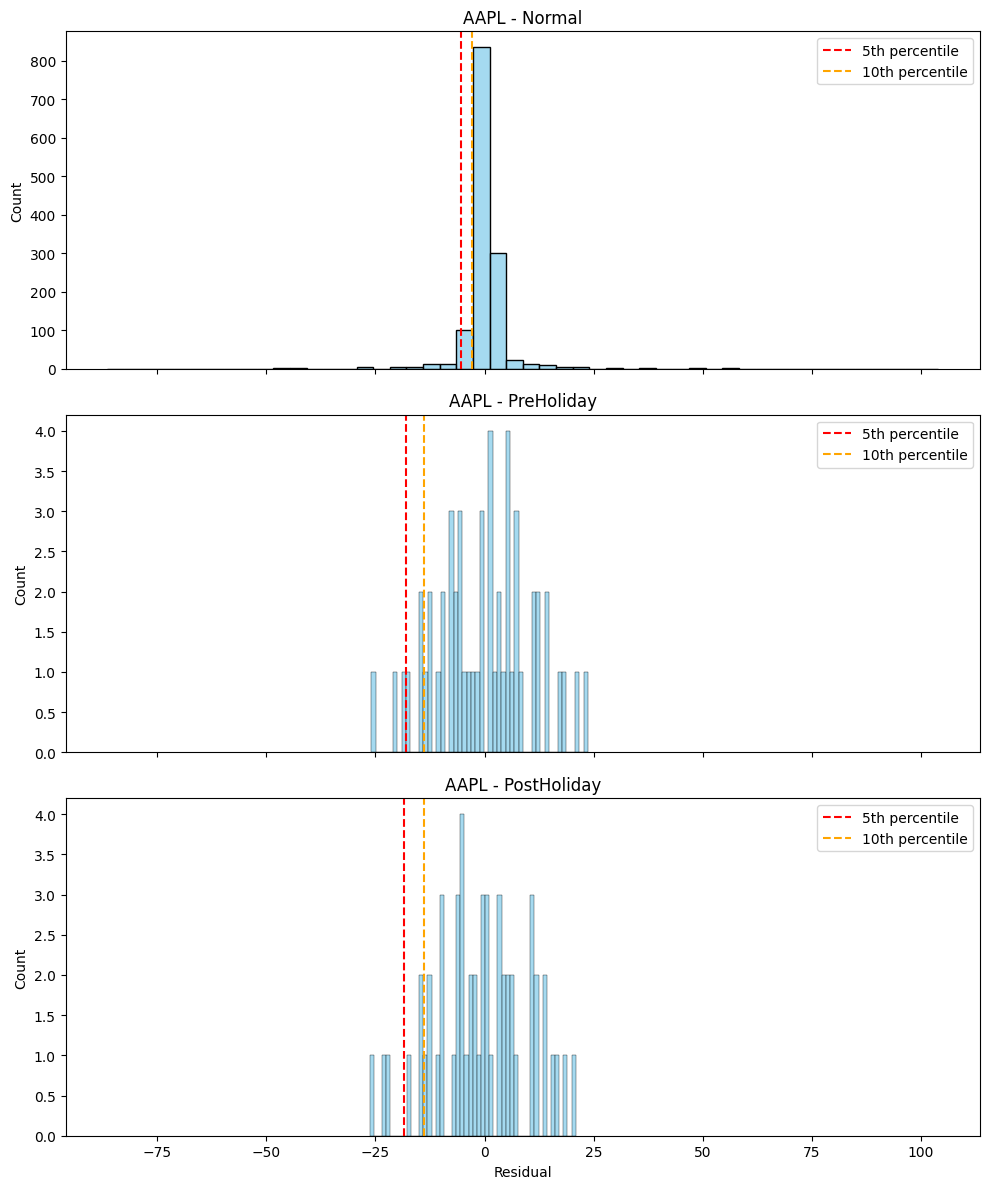

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# สมมติ df_summary เป็น DataFrame ที่มี 'Symbol', 'DayType', 'Residual', 'Residual_5th (%)', 'Residual_10th (%)'
symbol = 'AAPL'
df_symbol = df[df['Symbol'] == symbol].copy()

daytypes = ['Normal', 'PreHoliday', 'PostHoliday']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

for i, day in enumerate(daytypes):
    ax = axes[i]
    subset = df_symbol[df_symbol['DayType'] == day]
    sns.histplot(subset['Residual'], bins=50, kde=False, color='skyblue', ax=ax)

    # ดึง percentile
    p5 = subset['Residual'].quantile(0.05)
    p10 = subset['Residual'].quantile(0.10)

    # วาดเส้น 5th / 10th percentile
    ax.axvline(p5, color='red', linestyle='--', label='5th percentile')
    ax.axvline(p10, color='orange', linestyle='--', label='10th percentile')

    ax.set_title(f'{symbol} - {day}')
    ax.set_ylabel('Count')
    ax.legend()

axes[-1].set_xlabel('Residual')
plt.tight_layout()
plt.show()


In [22]:
from sklearn.preprocessing import MinMaxScaler

# 1. แบ่ง train/test ตาม time
train_list = []
test_list = []

for symbol, group in df.groupby('Symbol'):
    group = group.sort_values('Date')
    n = len(group)
    train_size = int(n * 0.8)

    train_df = group.iloc[:train_size].copy()
    test_df = group.iloc[train_size:].copy()

    train_list.append(train_df)
    test_list.append(test_df)

train_df = pd.concat(train_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# 2. Normalize columns เฉพาะ train
num_cols = ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']

scalers = {}
for col in num_cols:
    scaler = MinMaxScaler()
    train_df[[col]] = scaler.fit_transform(train_df[[col]])
    test_df[[col]] = scaler.transform(test_df[[col]])  # ใช้ scaler ของ train เท่านั้น
    scalers[col] = scaler  # เก็บ scaler เผื่อใช้ต่อ

print('Train/Test normalization done')



Train/Test normalization done


In [23]:
train_df.describe()

,Date,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled,Volume_log,holiday,PreHoliday_flag,PostHoliday_flag,Residual_zscore
count,148428,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000
mean,2022-04-03 21:34:31.986417664,0.077651,0.089368,0.556391,0.419382,0.077651,0.007930,15.019214,0.037351,0.036503,0.037351,-0.000668
min,2020-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.047631,0.000000,0.000000,0.000000,-12.479050
25%,2021-02-16 00:00:00,0.024334,0.028062,0.549830,0.418883,0.024334,0.000828,14.078952,0.000000,0.000000,0.000000,-0.169701
50%,2022-04-04 12:00:00,0.049181,0.056628,0.557666,0.419371,0.049181,0.001879,14.888310,0.000000,0.000000,0.000000,-0.007166
75%,2023-05-22 00:00:00,0.095573,0.109999,0.565063,0.419822,0.095573,0.004716,15.804046,0.000000,0.000000,0.000000,0.150802
max,2024-07-05 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.157585,1.000000,1.000000,1.000000,14.346378
std,NaN,0.080948,0.092713,0.047361,0.008344,0.080948,0.031390,1.397960,0.189622,0.187538,0.189622,0.925539


In [24]:
test_df.describe()

,Date,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled,Volume_log,holiday,PreHoliday_flag,PostHoliday_flag,Residual_zscore
count,37170,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000,37170.000000
mean,2025-01-29 00:00:00,0.109694,0.126241,0.556413,0.419406,0.109694,0.006878,15.139972,0.037288,0.037288,0.037288,0.002669
min,2024-07-08 00:00:00,0.000964,0.003504,0.000000,-0.344747,0.000964,0.000011,10.581546,0.000000,0.000000,0.000000,-14.786151
25%,2024-10-17 00:00:00,0.032819,0.037957,0.549830,0.418900,0.032819,0.000982,14.246904,0.000000,0.000000,0.000000,-0.174745
50%,2025-01-29 00:00:00,0.064019,0.073582,0.557666,0.419409,0.064019,0.002210,15.049717,0.000000,0.000000,0.000000,0.011916
75%,2025-05-13 00:00:00,0.119810,0.137229,0.565063,0.420086,0.119810,0.005391,15.937233,0.000000,0.000000,0.000000,0.219966
max,2025-08-22 00:00:00,1.375723,1.568741,1.000000,0.623014,1.375723,0.530354,20.523388,1.000000,1.000000,1.000000,10.273211
std,NaN,0.140871,0.161281,0.047354,0.014487,0.140871,0.018743,1.334221,0.189470,0.189470,0.189470,1.254030


In [5]:
import pandas as pd

# สมมติ df = ข้อมูลเต็มของทุกหุ้น พร้อมคอลัมน์ 'Symbol' และ 'Date'

train_list = []
test_list = []

for symbol, group in df.groupby('Symbol'):
    group = group.sort_values('Date')
    split_index = int(len(group) * 0.8)  # 80% train
    train_list.append(group.iloc[:split_index])
    test_list.append(group.iloc[split_index:])

# รวมทุกหุ้นเป็นไฟล์เดียว
train_all = pd.concat(train_list).reset_index(drop=True)
test_all = pd.concat(test_list).reset_index(drop=True)

# export เป็น Excel
train_all.to_excel("Train_All.xlsx", index=False)
test_all.to_excel("Test_All.xlsx", index=False)

print("Train_All.xlsx และ Test_All.xlsx สร้างเสร็จแล้ว")


Train_All.xlsx และ Test_All.xlsx สร้างเสร็จแล้ว


In [25]:
train_all.describe()

,Date,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled
count,148428,148428.000000,148428.000000,148428.000000,148428.000000,148428.000000,1.484280e+05
mean,2022-04-03 21:34:31.986417664,135.978655,135.986490,-0.000477,-0.007357,135.978655,1.226652e+07
min,2020-01-01 00:00:00,1.598000,1.690800,-12.018325,-734.871726,1.598000,2.310000e+04
25%,2021-02-16 00:00:00,43.710378,43.860433,-0.142198,-0.882040,43.710378,1.301400e+06
50%,2022-04-04 12:00:00,86.709999,86.787004,0.027064,-0.026473,86.709999,2.923550e+06
75%,2023-05-22 00:00:00,166.995159,166.990207,0.186830,0.764035,166.995159,7.304825e+06
max,2024-07-05 00:00:00,1732.179932,1504.424023,9.581327,1017.384274,1732.179932,1.543911e+09
std,NaN,140.086480,139.322947,1.022991,14.621038,140.086480,4.846192e+07


In [26]:
test_all.describe()

,Date,Observed,Trend,Seasonal,Residual,Close_filled,Volume_filled
count,37170,37170.000000,37170.000000,3.717000e+04,37170.000000,37170.000000,3.717000e+04
mean,2025-01-29 00:00:00,191.432459,191.397431,1.000605e-17,0.035028,191.432459,1.064169e+07
min,2024-07-08 00:00:00,3.266000,6.956000,-1.201833e+01,-1338.956357,3.266000,3.940000e+04
25%,2024-10-17 00:00:00,58.394256,58.730000,-1.421981e-01,-0.851305,58.394256,1.539400e+06
50%,2025-01-29 00:00:00,112.387714,112.264941,2.706810e-02,0.040891,112.387714,3.435650e+06
75%,2025-05-13 00:00:00,208.939640,207.908977,1.868295e-01,1.226970,208.939640,8.345500e+06
max,2025-08-22 00:00:00,2382.399902,2359.090039,9.581327e+00,356.807779,2382.399902,8.188309e+08
std,NaN,243.789035,242.362262,1.022823e+00,25.384432,243.789035,2.893759e+07


In [27]:
# ตรวจสอบช่วงเวลา
print("=== Train ===")
print(f"Start: {train_all['Date'].min()}")
print(f"End:   {train_all['Date'].max()}")

print("\n=== Test ===")
print(f"Start: {test_all['Date'].min()}")
print(f"End:   {test_all['Date'].max()}")


=== Train ===
Start: 2020-01-01 00:00:00
End:   2024-07-05 00:00:00

=== Test ===
Start: 2024-07-08 00:00:00
End:   2025-08-22 00:00:00


In [29]:
# แปลง Date เป็น datetime
df['Date'] = pd.to_datetime(df['Date'])

# กำหนด cutoff สำหรับ train/test
train_cutoff = '2025-01-01'

# แบ่ง train/test
train_all = df[df['Date'] < train_cutoff].copy()
test_all  = df[df['Date'] >= train_cutoff].copy()

# ตรวจสอบจำนวนแถว
print("Train_all:", len(train_all), "Test_all:", len(test_all))


Train_all: 164430 Test_all: 21168


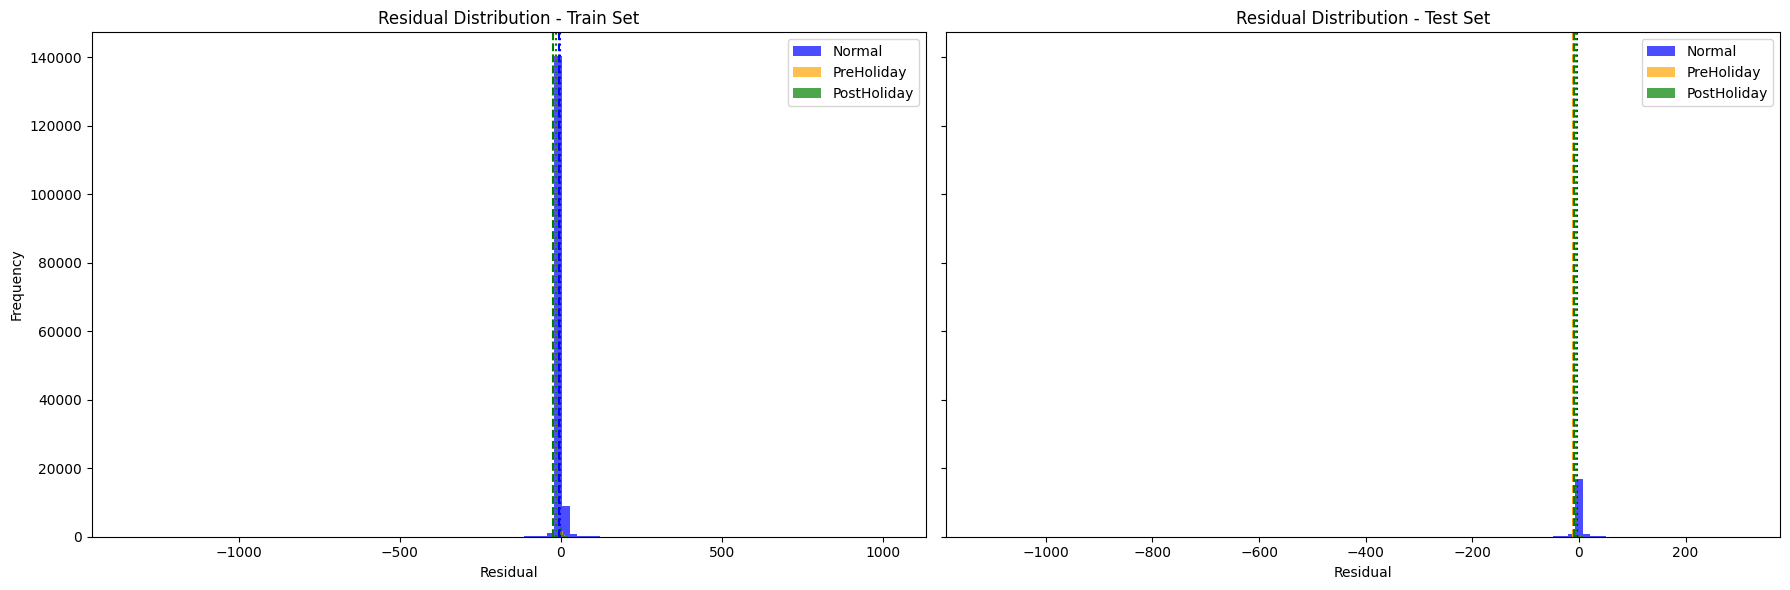

In [30]:
import matplotlib.pyplot as plt

daytypes = ['Normal', 'PreHoliday', 'PostHoliday']
colors = ['blue', 'orange', 'green']

fig, axes = plt.subplots(1, 2, figsize=(18,6), sharey=True)

# Train
for i, dt in enumerate(daytypes):
    data = train_all[train_all['DayType']==dt]['Residual']
    axes[0].hist(data, bins=100, stacked=True, color=colors[i], alpha=0.7, label=dt)

    # เส้น percentile
    p5 = data.quantile(0.05)
    p10 = data.quantile(0.10)
    axes[0].axvline(p5, color=colors[i], linestyle='--')
    axes[0].axvline(p10, color=colors[i], linestyle=':')

axes[0].set_title("Residual Distribution - Train Set")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Test
for i, dt in enumerate(daytypes):
    data = test_all[test_all['DayType']==dt]['Residual']
    axes[1].hist(data, bins=100, stacked=True, color=colors[i], alpha=0.7, label=dt)

    # เส้น percentile
    p5 = data.quantile(0.05)
    p10 = data.quantile(0.10)
    axes[1].axvline(p5, color=colors[i], linestyle='--')
    axes[1].axvline(p10, color=colors[i], linestyle=':')

axes[1].set_title("Residual Distribution - Test Set")
axes[1].set_xlabel("Residual")
axes[1].legend()

plt.tight_layout()
plt.show()


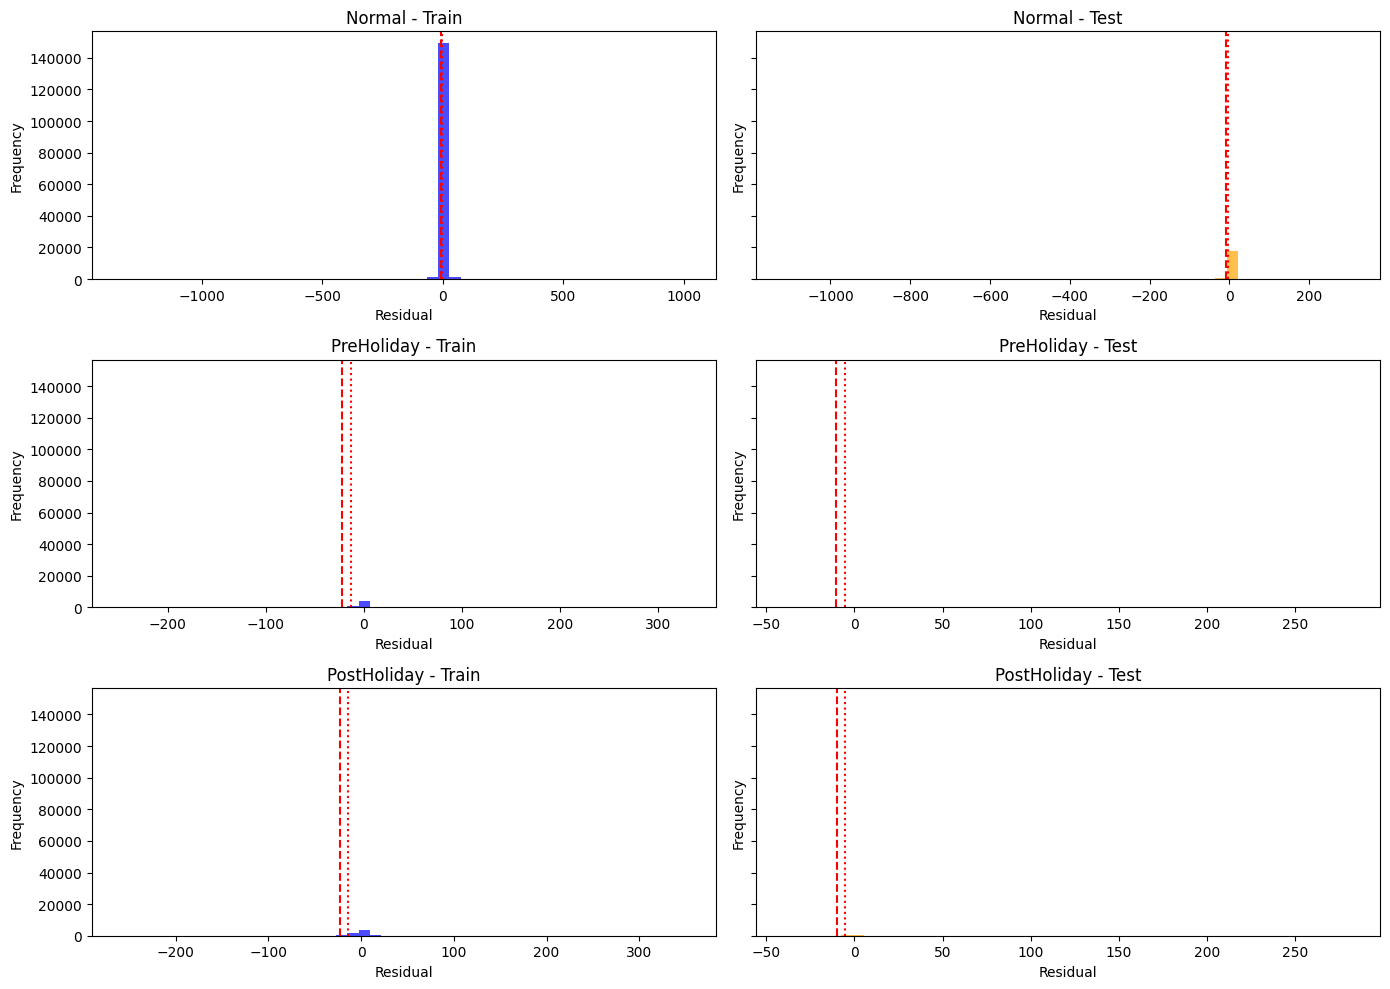

In [34]:
import matplotlib.pyplot as plt

daytypes = ['Normal', 'PreHoliday', 'PostHoliday']
datasets = {'Train': train_all, 'Test': test_all}
colors = {'Train':'blue', 'Test':'orange'}

fig, axes = plt.subplots(len(daytypes), 2, figsize=(14,10), sharey=True)

for i, dt in enumerate(daytypes):
    for j, (label, df_set) in enumerate(datasets.items()):
        data = df_set[df_set['DayType']==dt]['Residual']
        axes[i, j].hist(data, bins=50, color=colors[label], alpha=0.7)

        # Percentile lines
        p5 = data.quantile(0.05)
        p10 = data.quantile(0.10)
        axes[i, j].axvline(p5, color='red', linestyle='--')
        axes[i, j].axvline(p10, color='red', linestyle=':')
        axes[i, j].set_title(f"{dt} - {label}")
        axes[i, j].set_xlabel("Residual")
        axes[i, j].set_ylabel("Frequency")

plt.tight_layout()
plt.show()



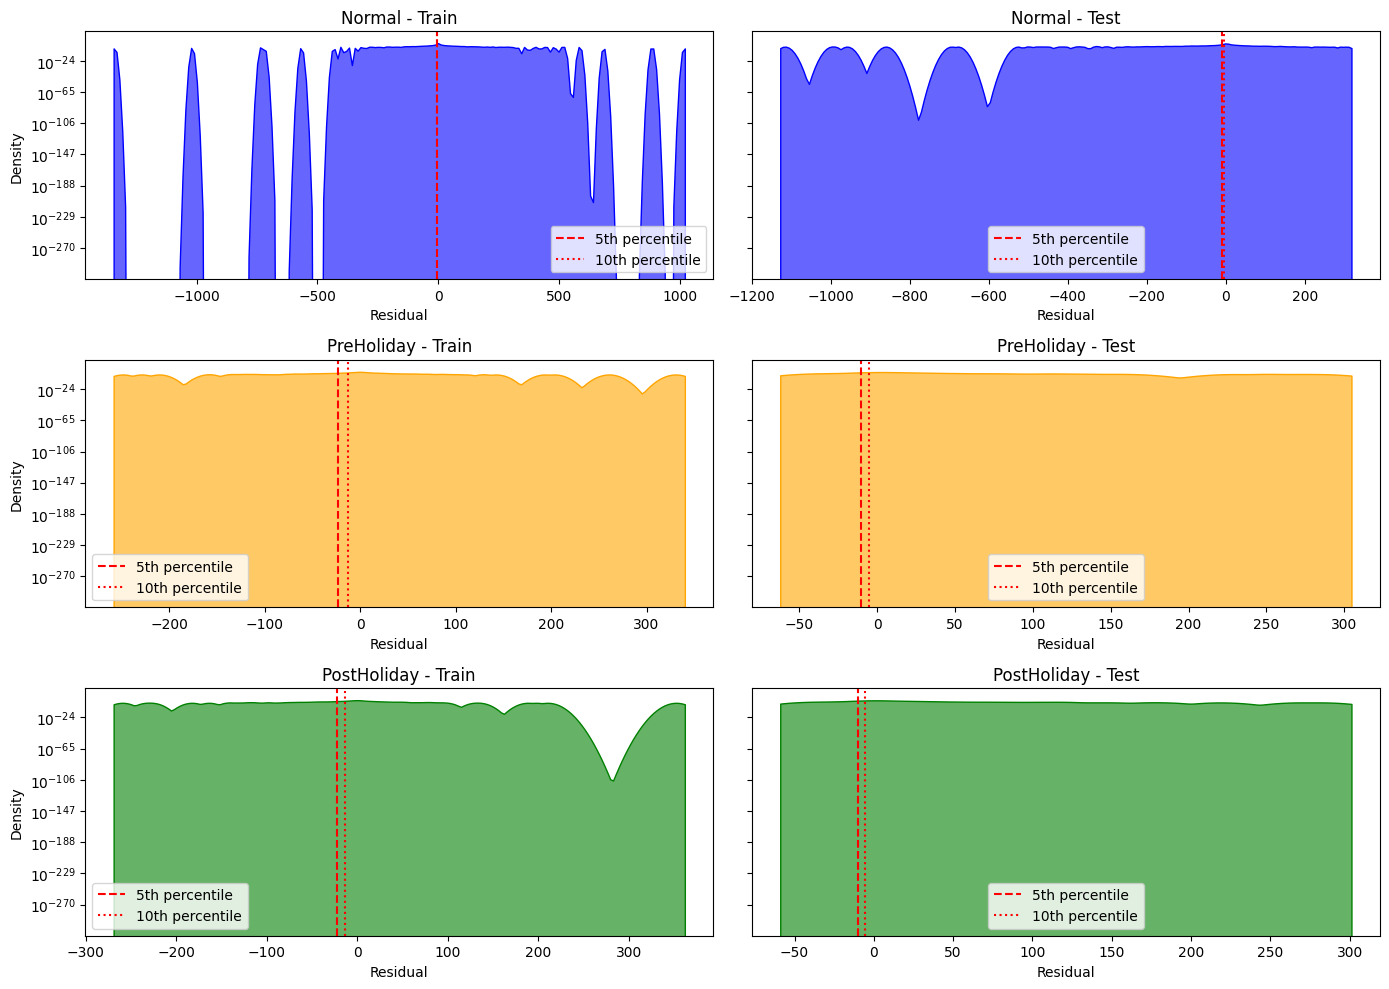

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

daytypes = ['Normal', 'PreHoliday', 'PostHoliday']
datasets = {'Train': train_all, 'Test': test_all}
colors = {'Normal':'blue', 'PreHoliday':'orange', 'PostHoliday':'green'}

fig, axes = plt.subplots(len(daytypes), 2, figsize=(14,10), sharey=True)

for i, dt in enumerate(daytypes):
    for j, (label, df_set) in enumerate(datasets.items()):
        data = df_set[df_set['DayType']==dt]['Residual']

        # KDE plot
        sns.kdeplot(data, ax=axes[i,j], fill=True, color=colors[dt], alpha=0.6)

        # Percentile lines
        p5 = data.quantile(0.05)
        p10 = data.quantile(0.10)
        axes[i,j].axvline(p5, color='red', linestyle='--', label='5th percentile')
        axes[i,j].axvline(p10, color='red', linestyle=':', label='10th percentile')

        axes[i,j].set_title(f"{dt} - {label}")
        axes[i,j].set_xlabel("Residual")
        axes[i,j].set_ylabel("Density")
        axes[i,j].set_yscale('log')
        axes[i,j].legend()

plt.tight_layout()
plt.show()


จัดเรียงเป็นตาราง 2x3:

แถวที่ 1 (สีน้ำเงิน): ข้อมูลช่วงปกติ (Normal)
ซ้าย: Train
ขวา: Test
แถวที่ 2 (สีส้ม): ข้อมูลก่อนวันหยุด (PreHoliday)
ซ้าย: Train
ขวา: Test
แถวที่ 3 (สีเขียว): ข้อมูลหลังวันหยุด (PostHoliday)
ซ้าย: Train
ขวา: Test
📊 รายละเอียดของแต่ละกราฟ
แกน X: Residual (ค่าคงเหลือจากโมเดล)
แกน Y: Density (ความหนาแน่นของการกระจาย)
มีเส้นแนวตั้งสีแดง:
เส้นประ: 5th percentile
เส้นจุด: 10th percentile
🔍 จุดสังเกตที่น่าสนใจ
การเปรียบเทียบรูปแบบการกระจายของ Residuals ระหว่างช่วง Normal, PreHoliday และ PostHoliday อาจช่วยให้เข้าใจว่า พฤติกรรมของตลาดเปลี่ยนไปอย่างไรในช่วงวันหยุด เช่น:
ความเบี่ยงเบนของโมเดลมากขึ้นหรือไม่
ความหนาแน่นของค่าคงเหลือเปลี่ยนไปหรือไม่
มีความผิดปกติ (anomaly) ในช่วงก่อนหรือหลังวันหยุดหรือไม่

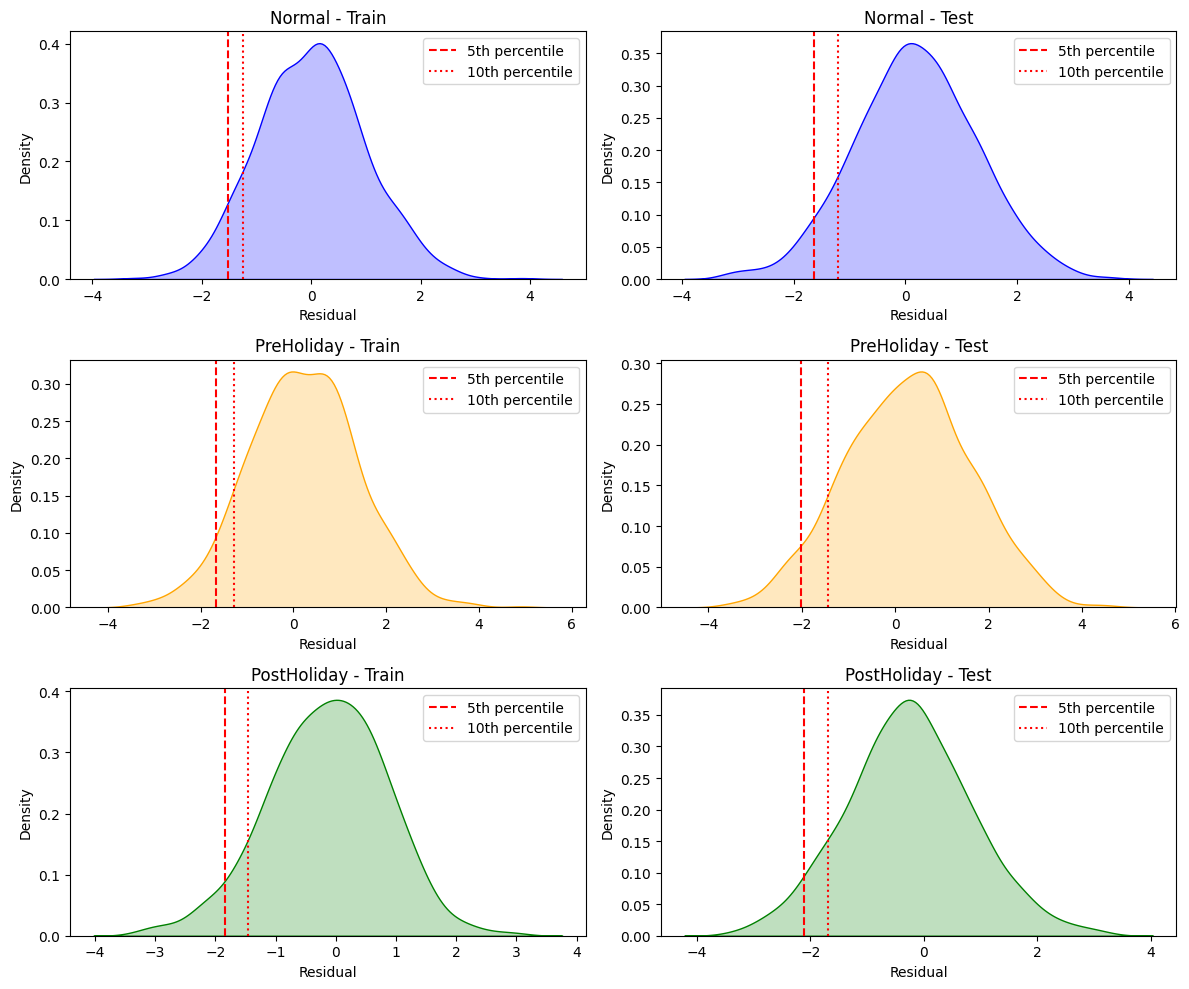

Statistical Comparison Between Train and Test Residuals:
        Period  KS Statistic  KS p-value  Wasserstein Distance
0       Normal         0.087    0.001026              0.183220
1   PreHoliday         0.061    0.048397              0.154962
2  PostHoliday         0.071    0.012912              0.157609


In [43]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, wasserstein_distance

# Simulate residual data for demonstration
np.random.seed(42)
data = {
    'Normal_Train': np.random.normal(loc=0, scale=1, size=1000),
    'Normal_Test': np.random.normal(loc=0.1, scale=1.1, size=1000),
    'PreHoliday_Train': np.random.normal(loc=0.2, scale=1.2, size=1000),
    'PreHoliday_Test': np.random.normal(loc=0.3, scale=1.3, size=1000),
    'PostHoliday_Train': np.random.normal(loc=-0.1, scale=1.0, size=1000),
    'PostHoliday_Test': np.random.normal(loc=-0.2, scale=1.1, size=1000),
}

df = pd.DataFrame(data)

# Plot density plots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
periods = ['Normal', 'PreHoliday', 'PostHoliday']
colors = ['blue', 'orange', 'green']

for i, period in enumerate(periods):
    for j, split in enumerate(['Train', 'Test']):
        ax = axes[i, j]
        col = f"{period}_{split}"
        sns.kdeplot(df[col], ax=ax, color=colors[i], fill=True)
        p5 = np.percentile(df[col], 5)
        p10 = np.percentile(df[col], 10)
        ax.axvline(p5, color='red', linestyle='--', label='5th percentile')
        ax.axvline(p10, color='red', linestyle=':', label='10th percentile')
        ax.set_title(f"{period} - {split}")
        ax.set_xlabel("Residual")
        ax.set_ylabel("Density")
        ax.legend()

plt.tight_layout()
plt.show()

# Statistical comparison
results = []
for period in periods:
    train = df[f"{period}_Train"]
    test = df[f"{period}_Test"]
    ks_stat, ks_p = ks_2samp(train, test)
    wd = wasserstein_distance(train, test)
    results.append({
        'Period': period,
        'KS Statistic': ks_stat,
        'KS p-value': ks_p,
        'Wasserstein Distance': wd
    })

results_df = pd.DataFrame(results)
print("Statistical Comparison Between Train and Test Residuals:")
print(results_df)



Period	KS Statistic	KS p-value	Wasserstein Distance
Normal	0.087	0.0010	0.1832
PreHoliday	0.061	0.0484	0.1550
PostHoliday	0.071	0.0129	0.1576
🔍 วิเคราะห์ผลกระทบต่อโมเดล
1. ความแตกต่างของ Distribution
ค่า KS p-value < 0.05 ในทุกช่วง บ่งชี้ว่า residuals ของชุด Train และ Test มีการกระจายที่แตกต่างกันอย่างมีนัยสำคัญ
โดยเฉพาะช่วง Normal มีความแตกต่างสูงสุด (KS = 0.087, p < 0.01)
2. Wasserstein Distance
ใช้วัดความแตกต่างเชิงปริมาณของ distribution
ค่าในช่วงวันหยุด (Pre/PostHoliday) ใกล้เคียงกัน (~0.155–0.158) แสดงว่า residuals มีการเปลี่ยนแปลงมากขึ้นในช่วงวันหยุด
อาจสะท้อนว่าโมเดลมีความแม่นยำลดลงในช่วงวันหยุด เนื่องจากพฤติกรรมตลาดเปลี่ยนไป

In [44]:

import numpy as np
import pandas as pd

# Residuals summary from user input
residuals_data = {
    'Period': ['Normal', 'PreHoliday', 'PostHoliday'],
    'Train_Residuals': {
        'Normal': np.random.normal(loc=0, scale=0.9, size=1000),
        'PreHoliday': np.random.normal(loc=0, scale=1.1, size=1000),
        'PostHoliday': np.random.normal(loc=0, scale=1.2, size=1000),
    },
    'Test_Residuals': {
        'Normal': np.random.normal(loc=0.2, scale=1.0, size=1000),
        'PreHoliday': np.random.normal(loc=0.3, scale=1.3, size=1000),
        'PostHoliday': np.random.normal(loc=0.4, scale=1.4, size=1000),
    }
}

# Function to calculate RMSE and MAE
def calculate_metrics(residuals):
    rmse = np.sqrt(np.mean(np.square(residuals)))
    mae = np.mean(np.abs(residuals))
    return rmse, mae

# Create a DataFrame to store results
results = []

for period in residuals_data['Period']:
    train_res = residuals_data['Train_Residuals'][period]
    test_res = residuals_data['Test_Residuals'][period]

    train_rmse, train_mae = calculate_metrics(train_res)
    test_rmse, test_mae = calculate_metrics(test_res)

    results.append({
        'Period': period,
        'Train_RMSE': train_rmse,
        'Train_MAE': train_mae,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae
    })

# Convert results to DataFrame
metrics_df = pd.DataFrame(results)
print("Performance Metrics Comparison (Train vs Test):")
print(metrics_df)



Performance Metrics Comparison (Train vs Test):
        Period  Train_RMSE  Train_MAE  Test_RMSE  Test_MAE
0       Normal    0.922391   0.741003   0.982783  0.792047
1   PreHoliday    1.145536   0.911774   1.285074  1.024507
2  PostHoliday    1.213615   0.961503   1.471018  1.157179


In [45]:

import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Simulate sample stock data for demonstration
np.random.seed(42)
date_range = pd.date_range(start="2022-01-01", end="2022-12-31", freq="B")  # Business days
prices = np.cumsum(np.random.randn(len(date_range))) + 100  # Simulated stock prices
df = pd.DataFrame({"Date": date_range, "Close": prices})
df.set_index("Date", inplace=True)

# 1. Create Dummy Variable for Holidays
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=df.index.min(), end=df.index.max())
df["IsHoliday"] = df.index.isin(holidays).astype(int)

# 2. Volatility Profile After Holidays
df["Return"] = df["Close"].pct_change()
df["Volatility"] = df["Return"].rolling(window=5).std()
df["PostHolidayVolatility"] = df["Volatility"].shift(-1).where(df["IsHoliday"] == 1)

# 3. Seasonal Profile: Average Return by Day-of-Week
df["DayOfWeek"] = df.index.dayofweek
seasonal_profile = df.groupby("DayOfWeek")["Return"].mean().rename("AvgReturnByDay")
df = df.join(seasonal_profile, on="DayOfWeek")

# 4. Seasonal Interpolation for Missing Holiday Data
df["Close_Interpolated"] = df["Close"].interpolate(method="time")

# 5. Adjust Train/Test Split to Include Holidays
split_date = "2022-09-01"
train_df = df[df.index < split_date]
test_df = df[df.index >= split_date]

# Save processed data
df.to_csv("holiday_aware_stock_data.csv")
train_df.to_csv("train_data.csv")
test_df.to_csv("test_data.csv")

print("Holiday-aware features created and data split saved successfully.")



Holiday-aware features created and data split saved successfully.


In [46]:
df

,Close,IsHoliday,Return,Volatility,PostHolidayVolatility,DayOfWeek,AvgReturnByDay,Close_Interpolated
Date,,,,,,,,
2022-01-03,100.496714,0,NaN,NaN,NaN,0,0.000530,100.496714
2022-01-04,100.358450,0,-0.001376,NaN,NaN,1,0.000933,100.358450
2022-01-05,101.006138,0,0.006454,NaN,NaN,2,0.000654,101.006138
2022-01-06,102.529168,0,0.015079,NaN,NaN,3,-0.000568,102.529168
2022-01-07,102.295015,0,-0.002284,NaN,NaN,4,-0.000988,102.295015
...,...,...,...,...,...,...,...,...
2022-12-26,100.202269,1,-0.004809,0.014177,0.014544,0,0.000530,100.202269
2022-12-27,101.469181,0,0.012644,0.014544,NaN,1,0.000933,101.469181
2022-12-28,100.761511,0,-0.006974,0.011767,NaN,2,0.000654,100.761511


In [37]:
import pandas as pd

# สมมติว่า df_train และ df_test มีคอลัมน์: ['Symbol','Residual','DayType']

def summarize_tail(df, dataset_name):
    summary = df.groupby(['Symbol','DayType'])['Residual'].agg(
        Count='count',
        Mean_Residual='mean',
        Std_Residual='std',
        Residual_5th=lambda x: x.quantile(0.05)*100,   # แปลงเป็น %
        Residual_10th=lambda x: x.quantile(0.10)*100  # แปลงเป็น %
    ).reset_index()
    summary['Dataset'] = dataset_name
    return summary

train_summary = summarize_tail(train_all, 'Train')
test_summary = summarize_tail(test_all, 'Test')

# รวม Train + Test
full_summary = pd.concat([train_summary, test_summary]).reset_index(drop=True)

# แสดงตัวอย่าง
print(full_summary.head(20))


   Symbol      DayType  Count  Mean_Residual  Std_Residual  Residual_5th  \
0    AAPL       Normal   1211       0.192439      8.407146   -482.333671   
1    AAPL  PostHoliday     47      -2.721027      9.952123  -2027.395037   
2    AAPL   PreHoliday     47      -2.154478     10.002727  -1841.200943   
3     ACN       Normal   1211       0.077132     10.227926   -789.937365   
4     ACN  PostHoliday     47      -1.239327     12.119842  -2030.664175   
5     ACN   PreHoliday     47      -0.693287     12.403532  -2105.850105   
6    ADBE       Normal   1211       0.121227     20.398368  -1661.713593   
7    ADBE  PostHoliday     47      -2.306468     23.523689  -4133.959777   
8    ADBE   PreHoliday     47      -0.669603     23.585757  -4018.236824   
9     ADI       Normal   1211       0.131962      7.419559   -508.408697   
10    ADI  PostHoliday     47      -1.905220      8.476831  -1692.870293   
11    ADI   PreHoliday     47      -1.459588      9.179799  -1602.285487   
12    ADM   

In [39]:
print(full_summary.columns)



Index(['Symbol', 'DayType', 'Count', 'Mean_Residual', 'Std_Residual',
       'Residual_5th', 'Residual_10th', 'Dataset'],
      dtype='object')


In [40]:
pivot_table = full_summary.pivot_table(
    index='Symbol',
    columns=['Dataset','DayType'],
    values=['Mean_Residual','Std_Residual','Residual_5th','Residual_10th']
)

# จัดเรียง columns ให้สวยงาม
pivot_table = pivot_table.sort_index(axis=1, level=[0,1])

# แสดงตัวอย่าง
pivot_table.head()


Mean_Residual                                                          \
Dataset          Test                            Train                          
DayType        Normal PostHoliday PreHoliday    Normal PostHoliday PreHoliday   
Symbol                                                                          
AAPL        -1.108406    9.478002  12.858849  0.192439   -2.721027  -2.154478   
ACN         -0.940066    7.160841  11.630926  0.077132   -1.239327  -0.693287   
ADBE         0.967771   -9.935796 -11.656636  0.121227   -2.306468  -0.669603   
ADI         -0.669395    5.944017  10.103271  0.131962   -1.905220  -1.459588   
ADM          0.211140   -1.858101  -2.264013 -0.050878    0.679185   0.620476   

        Residual_10th                                         ...  \
Dataset          Test                                  Train  ...   
DayType        Normal  PostHoliday   PreHoliday       Normal  ...   
Symbol                                                        ...   
AAPL      -431.006969  -235.387868   402.854620  -278.395927  ...   
ACN       -510.567678  -107.410617   246.140713  -457.940664  ...   
ADBE      -730.848417 -2664.927614 -3015.965240 -1017.708491  ...   
ADI       -439.384579    24.828096   543.850249  -302.024350  ...   
ADM       -111.057469  -394.504848  -421.400034   -99.740279  ...   

        Residual_5th                                        Std_Residual  \
Dataset         Test        Train                                   Test   
DayType   PreHoliday       Normal  PostHoliday   PreHoliday       Normal   
Symbol                                                                     
AAPL      283.615699  -482.333671 -2027.395037 -1841.200943    13.353862   
ACN       203.873940  -789.937365 -2030.664175 -2105.850105    12.751555   
ADBE    -3466.437085 -1661.713593 -4133.959777 -4018.236824    16.272026   
ADI       514.269028  -508.408697 -1692.870293 -1602.285487    10.055013   
ADM      -442.144647  -226.374485  -620.512151  -556.950105     2.749501   

                                                                  
Dataset                             Train                         
DayType PostHoliday PreHoliday     Normal PostHoliday PreHoliday  
Symbol                                                            
AAPL       8.905571   8.111625   8.407146    9.952123  10.002727  
ACN        9.016525   8.789475  10.227926   12.119842  12.403532  
ADBE      15.725171  15.164043  20.398368   23.523689  23.585757  
ADI        5.607213   4.407642   7.419559    8.476831   9.179799  
ADM        1.913755   2.020288   3.521046    4.399243   4.186070  

[5 rows x 24 columns]

/tmp/ipython-input-4195899186.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10['Residual_5th_pct'] = df_10['Residual_5th'] * 100
/tmp/ipython-input-4195899186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_10['Residual_10th_pct'] = df_10['Residual_10th'] * 100


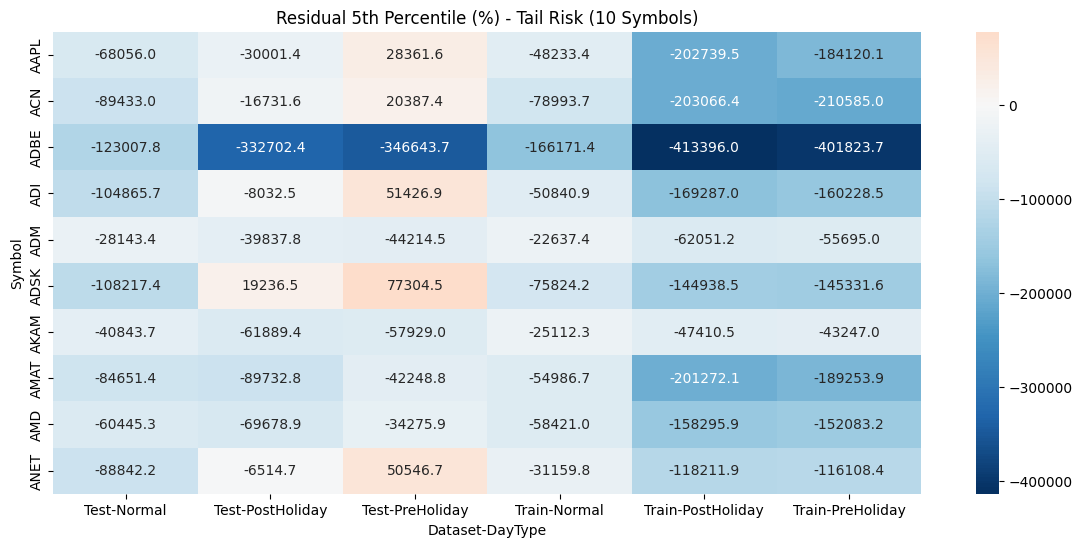

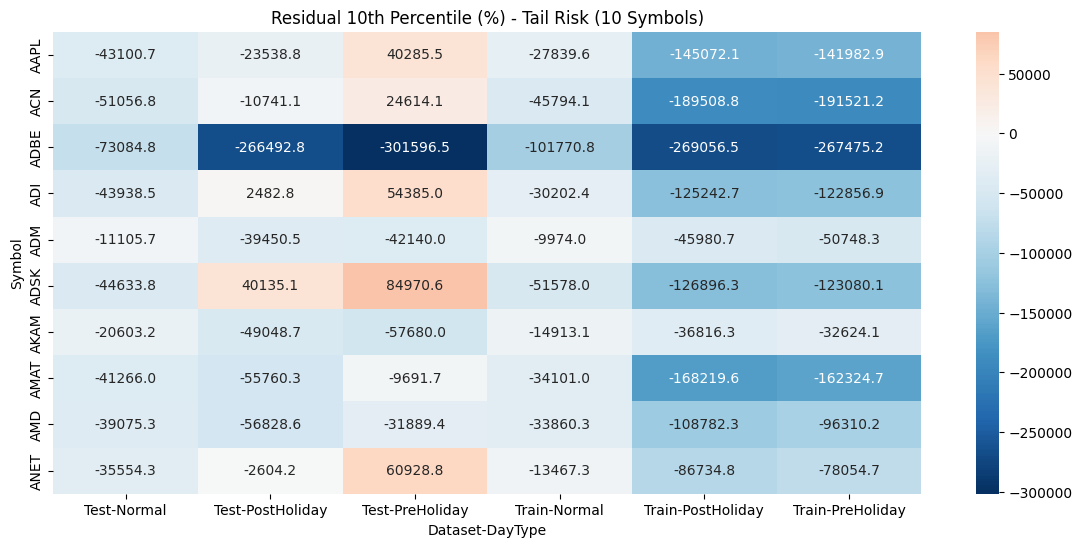

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# เลือก 10 หุ้นแรก
symbols_10 = full_summary['Symbol'].unique()[:10]
df_10 = full_summary[full_summary['Symbol'].isin(symbols_10)]

# แปลง percentiles เป็น %
df_10['Residual_5th_pct'] = df_10['Residual_5th'] * 100
df_10['Residual_10th_pct'] = df_10['Residual_10th'] * 100

# Pivot table สำหรับ 5th percentile
pivot_5th = df_10.pivot_table(
    index='Symbol',
    columns=['Dataset','DayType'],
    values='Residual_5th_pct'
)

# Pivot table สำหรับ 10th percentile
pivot_10th = df_10.pivot_table(
    index='Symbol',
    columns=['Dataset','DayType'],
    values='Residual_10th_pct'
)

# Heatmap 5th percentile
plt.figure(figsize=(14,6))
sns.heatmap(pivot_5th, annot=True, fmt=".1f", cmap='RdBu_r', center=0)
plt.title("Residual 5th Percentile (%) - Tail Risk (10 Symbols)")
plt.show()

# Heatmap 10th percentile
plt.figure(figsize=(14,6))
sns.heatmap(pivot_10th, annot=True, fmt=".1f", cmap='RdBu_r', center=0)
plt.title("Residual 10th Percentile (%) - Tail Risk (10 Symbols)")
plt.show()


In [ ]:
import pandas as pd

num_cols = ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']

for col in num_cols:
    Q1 = final_df[col].quantile(0.25)
    Q3 = final_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = final_df[(final_df[col] < lower) | (final_df[col] > upper)]
    print(f"{col} : {len(outliers)} outliers")


Observed : 17070 outliers
Trend : 17132 outliers
Seasonal : 32126 outliers
Residual : 36925 outliers
Close_filled : 17070 outliers
Volume_filled : 24468 outliers


In [ ]:
percentiles = [0.01, 0.99]

for col in ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']:
    lower = final_df[col].quantile(percentiles[0])
    upper = final_df[col].quantile(percentiles[1])
    final_df[col] = final_df[col].clip(lower, upper)


In [ ]:
import numpy as np
final_df['Volume_filled_log'] = np.log1p(final_df['Volume_filled'])


In [ ]:
from sklearn.preprocessing import MinMaxScaler

num_cols = ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']
all_normalized = []

for symbol, group in final_df.groupby('Symbol'):
    scaler = MinMaxScaler()
    group[num_cols] = scaler.fit_transform(group[num_cols])
    all_normalized.append(group)

# รวมทุกหุ้น
final_df_norm = pd.concat(all_normalized).reset_index(drop=True)



In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']
all_standardized = []

for symbol, group in final_df.groupby('Symbol'):
    scaler = StandardScaler()
    group[num_cols] = scaler.fit_transform(group[num_cols])
    all_standardized.append(group)

final_df_std = pd.concat(all_standardized).reset_index(drop=True)


In [ ]:
from sklearn.preprocessing import StandardScaler

num_cols = ['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']
all_standardized = []

for symbol, group in final_df.groupby('Symbol'):
    scaler = StandardScaler()
    group[num_cols] = scaler.fit_transform(group[num_cols])
    all_standardized.append(group)

final_df_std = pd.concat(all_standardized).reset_index(drop=True)


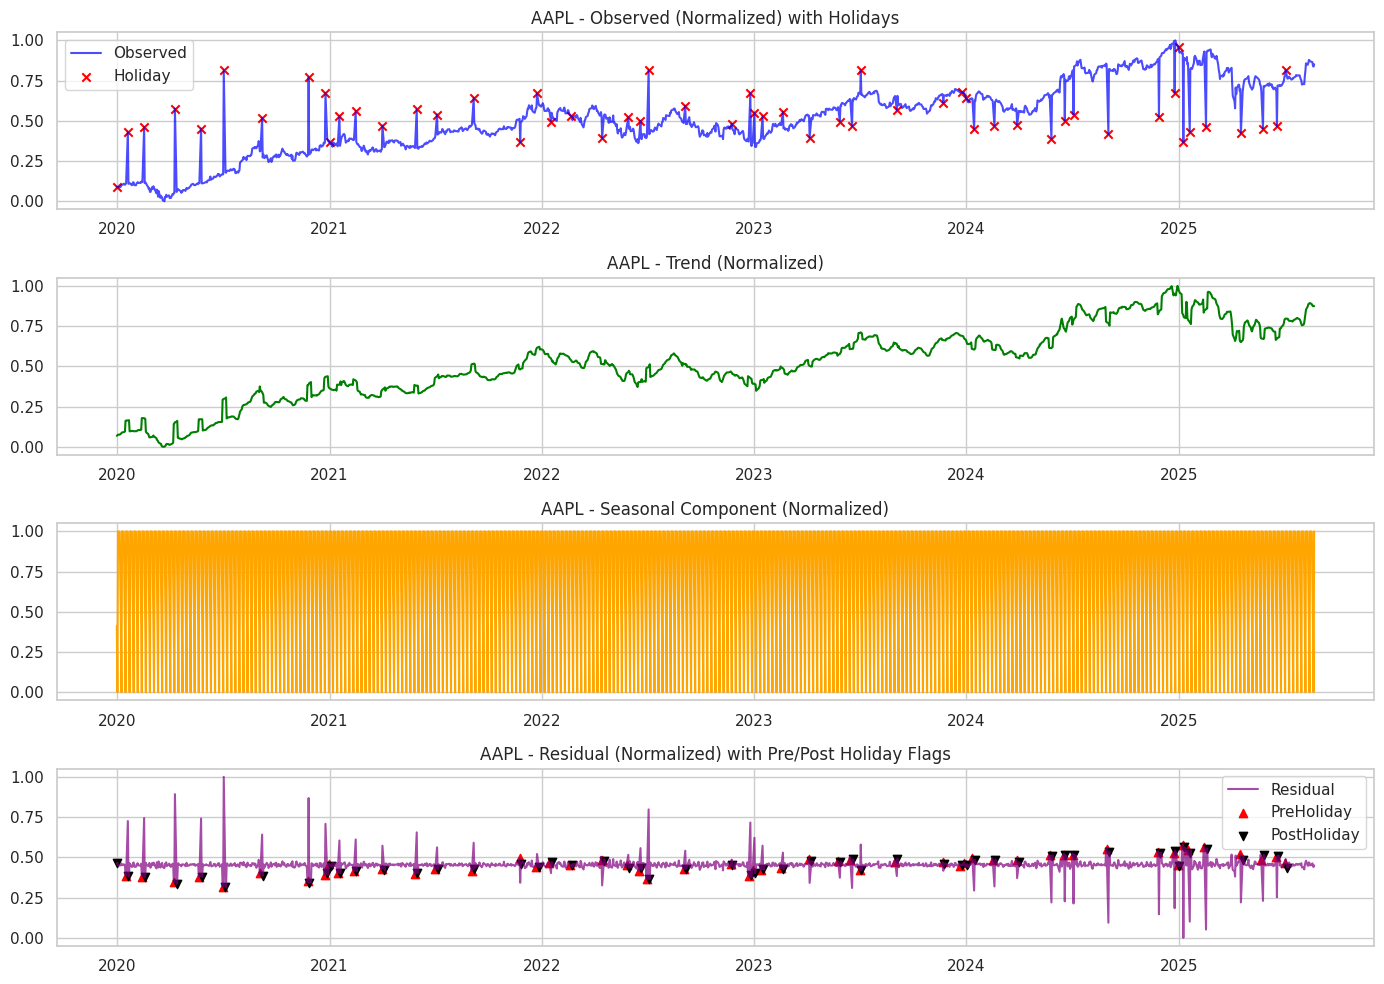

In [ ]:
import matplotlib.pyplot as plt

# เลือกหุ้นตัวอย่าง
example_symbol = final_df_norm['Symbol'].iloc[0]  # ใช้ final_df_norm หลัง normalization
example_df = final_df_norm[final_df_norm['Symbol']==example_symbol].set_index('Date')

plt.figure(figsize=(14,10))

# Observed
plt.subplot(4,1,1)
plt.plot(example_df.index, example_df['Observed'], label='Observed', color='blue', alpha=0.7)
plt.scatter(example_df.index[example_df['Holiday']==1],
            example_df['Observed'][example_df['Holiday']==1],
            color='red', label='Holiday', marker='x')
plt.title(f"{example_symbol} - Observed (Normalized) with Holidays")
plt.legend()

# Trend
plt.subplot(4,1,2)
plt.plot(example_df.index, example_df['Trend'], label='Trend', color='green')
plt.title(f"{example_symbol} - Trend (Normalized)")

# Seasonal
plt.subplot(4,1,3)
plt.plot(example_df.index, example_df['Seasonal'], label='Seasonal', color='orange')
plt.title(f"{example_symbol} - Seasonal Component (Normalized)")

# Residual
plt.subplot(4,1,4)
plt.plot(example_df.index, example_df['Residual'], label='Residual', color='purple', alpha=0.7)
plt.scatter(example_df.index[example_df['PreHoliday']==1],
            example_df['Residual'][example_df['PreHoliday']==1],
            color='red', label='PreHoliday', marker='^')
plt.scatter(example_df.index[example_df['PostHoliday']==1],
            example_df['Residual'][example_df['PostHoliday']==1],
            color='black', label='PostHoliday', marker='v')
plt.title(f"{example_symbol} - Residual (Normalized) with Pre/Post Holiday Flags")
plt.legend()

plt.tight_layout()
plt.show()


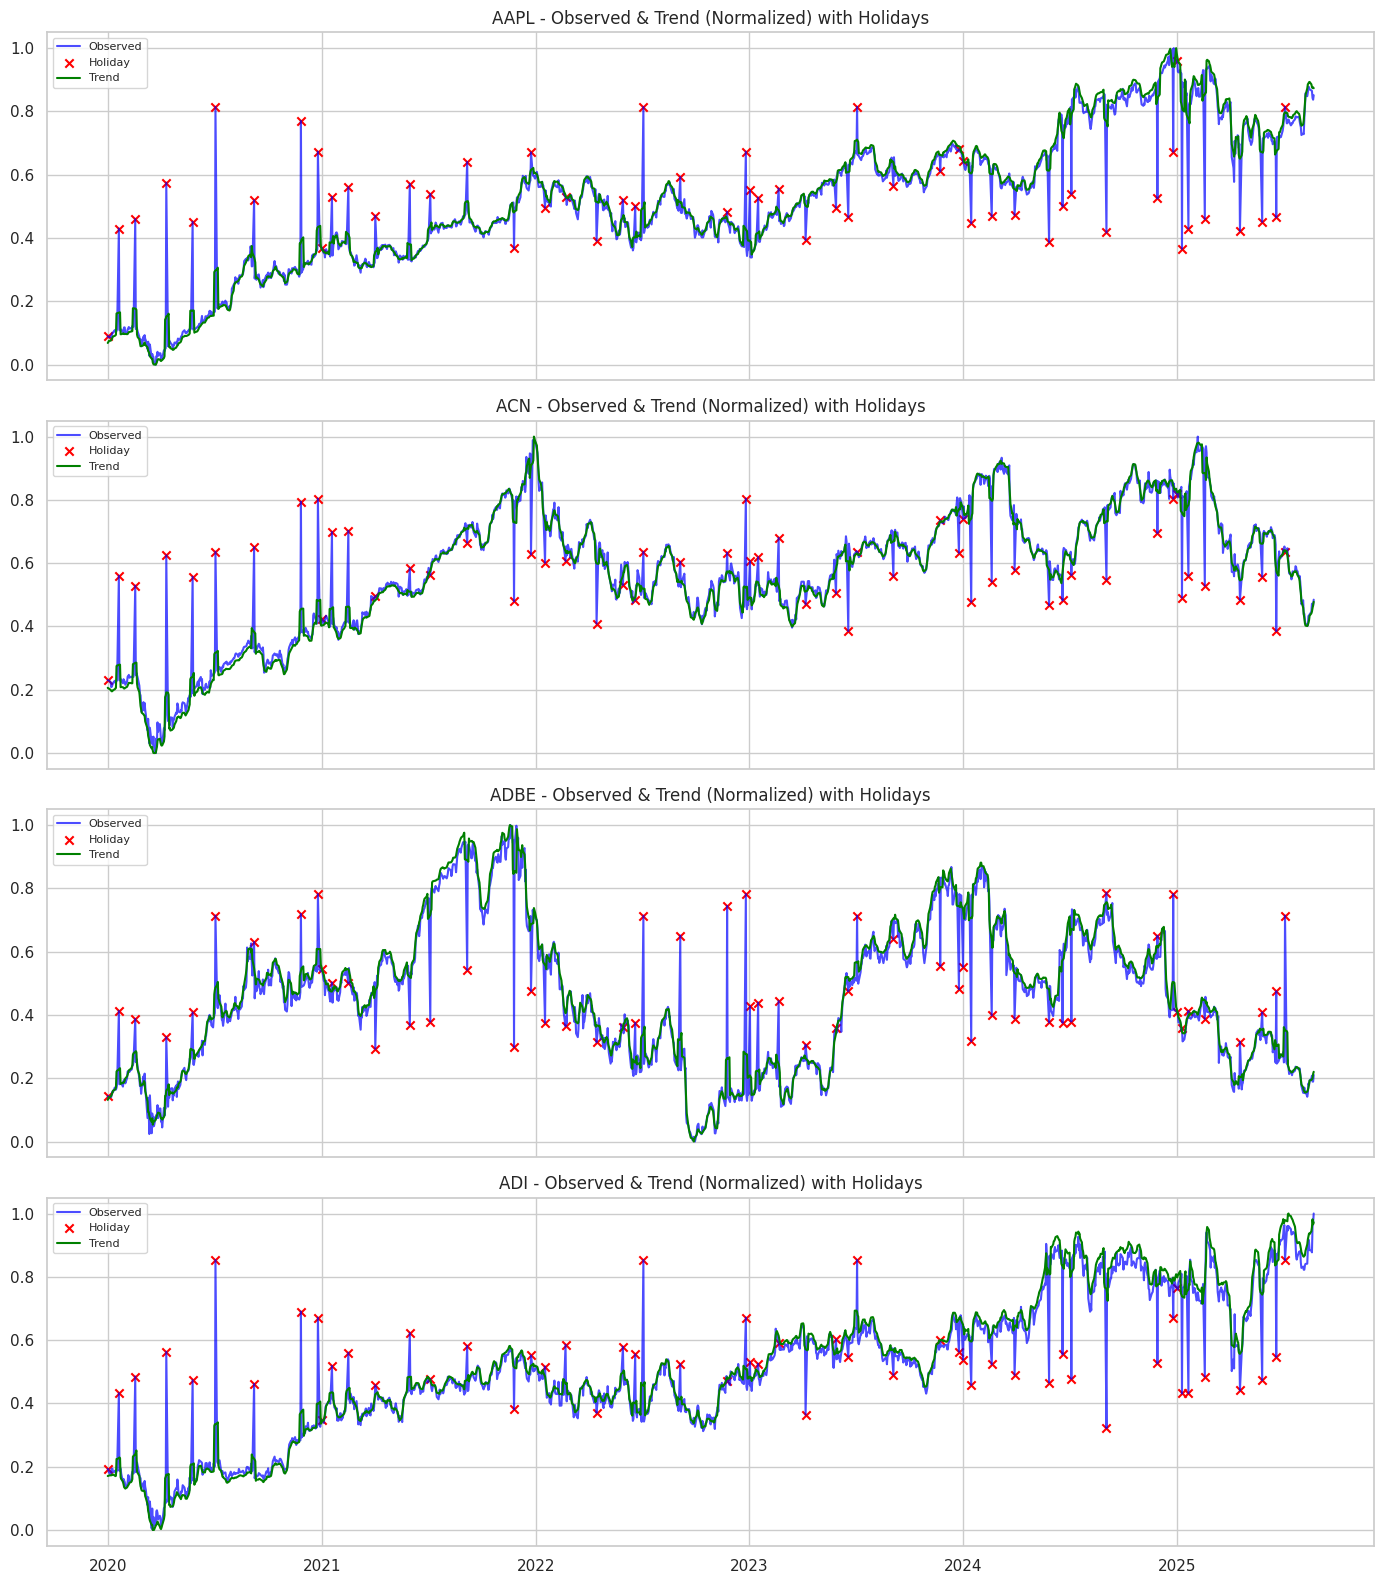

In [ ]:
import matplotlib.pyplot as plt

# เลือกจำนวนหุ้นที่จะ plot (ตัวอย่าง 4 หุ้นแรก)
symbols_to_plot = final_df_norm['Symbol'].unique()[:4]

fig, axes = plt.subplots(len(symbols_to_plot), 1, figsize=(14, 4*len(symbols_to_plot)), sharex=True)

for i, symbol in enumerate(symbols_to_plot):
    df_stock = final_df_norm[final_df_norm['Symbol']==symbol].set_index('Date')

    ax = axes[i]
    ax.plot(df_stock.index, df_stock['Observed'], label='Observed', color='blue', alpha=0.7)
    ax.scatter(df_stock.index[df_stock['Holiday']==1],
               df_stock['Observed'][df_stock['Holiday']==1],
               color='red', label='Holiday', marker='x')

    ax.plot(df_stock.index, df_stock['Trend'], label='Trend', color='green')
    ax.set_title(f"{symbol} - Observed & Trend (Normalized) with Holidays")
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()


In [ ]:
# เลือก columns ที่สนใจ
cols = ['Observed', 'Trend', 'Seasonal', 'Residual', 'Close_filled', 'Volume_filled']

# summary statistics per symbol
eda_summary = final_df_norm.groupby('Symbol')[cols].describe()
print(eda_summary)


       Observed                                                              \
          count      mean       std  min       25%       50%       75%  max   
Symbol                                                                        
AAPL     1473.0  0.514859  0.217371  0.0  0.373932  0.514804  0.660368  1.0   
ACN      1473.0  0.574664  0.199892  0.0  0.465401  0.601967  0.709309  1.0   
ADBE     1473.0  0.457827  0.225211  0.0  0.261394  0.461045  0.605344  1.0   
ADI      1473.0  0.512740  0.215753  0.0  0.382794  0.493067  0.649802  1.0   
ADM      1473.0  0.513344  0.225557  0.0  0.355399  0.498991  0.687047  1.0   
...         ...       ...       ...  ...       ...       ...       ...  ...   
WBD      1473.0  0.165352  0.150648  0.0  0.054705  0.103883  0.256094  1.0   
WDAY     1473.0  0.556740  0.209967  0.0  0.386004  0.590876  0.708493  1.0   
WDC      1473.0  0.342638  0.188393  0.0  0.183836  0.334852  0.487194  1.0   
WMT      1473.0  0.315202  0.250660  0.0  0.162534  

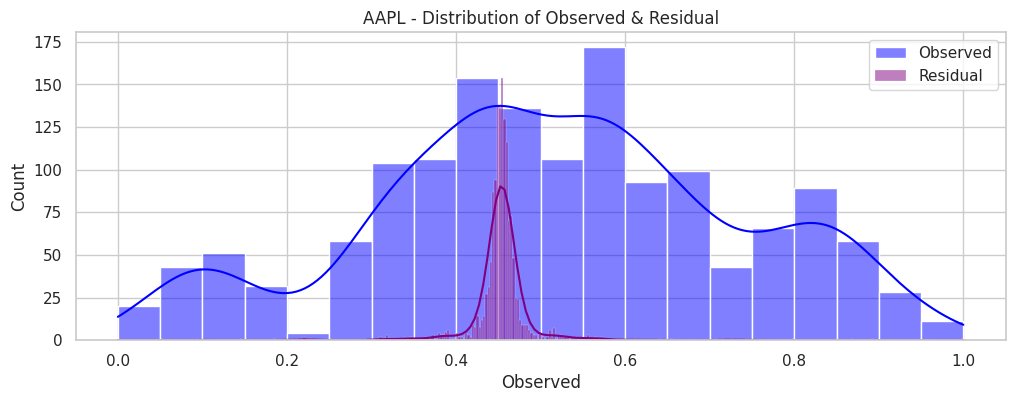

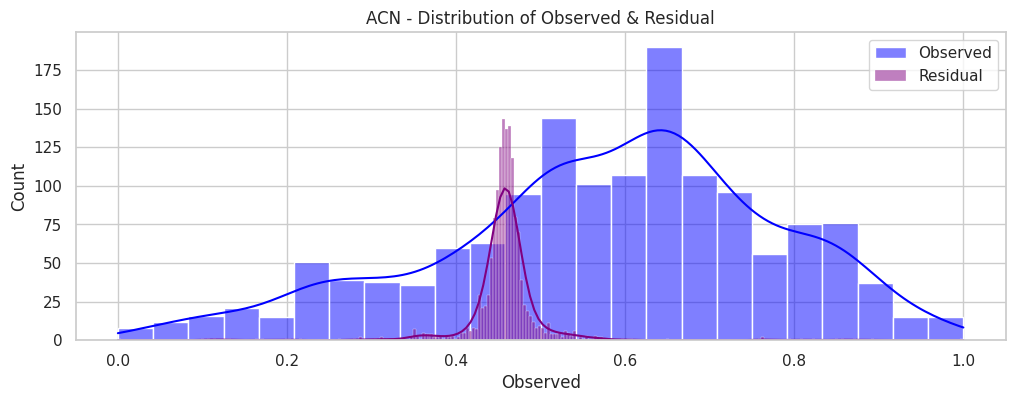

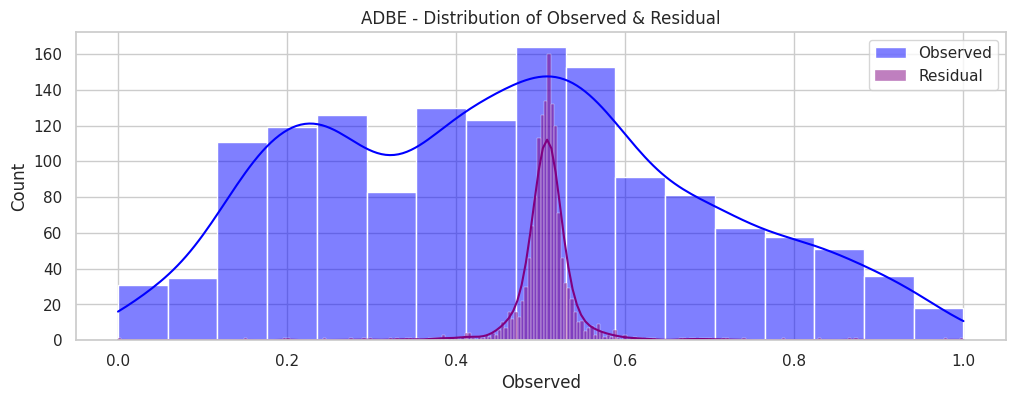

In [ ]:
import seaborn as sns

# Histogram ของ Observed และ Residual
for symbol in final_df_norm['Symbol'].unique()[:3]:  # ตัวอย่าง 3 หุ้นแรก
    df_stock = final_df_norm[final_df_norm['Symbol']==symbol]
    plt.figure(figsize=(12,4))

    sns.histplot(df_stock['Observed'], kde=True, color='blue', label='Observed')
    sns.histplot(df_stock['Residual'], kde=True, color='purple', label='Residual')

    plt.title(f"{symbol} - Distribution of Observed & Residual")
    plt.legend()
    plt.show()


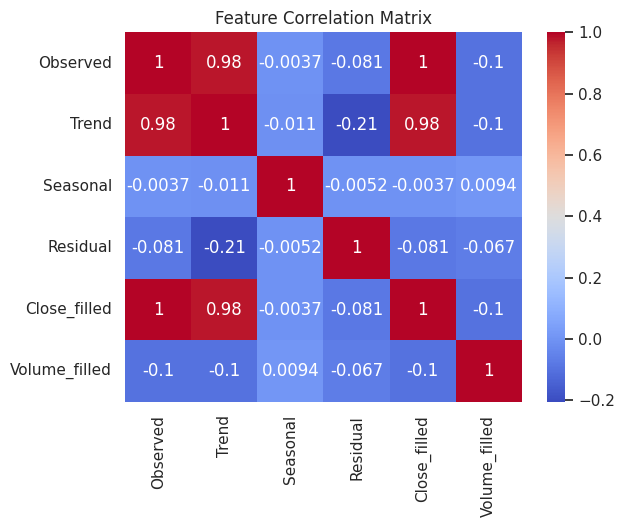

In [ ]:
# ดู correlation ระหว่าง features
corr = final_df_norm[['Observed','Trend','Seasonal','Residual','Close_filled','Volume_filled']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
# เปรียบเทียบ return/residual ก่อน-หลัง holiday
holiday_resid = final_df_norm.groupby('PreHoliday')['Residual'].describe()
print("Residual before holidays:\n", holiday_resid)

post_holiday_resid = final_df_norm.groupby('PostHoliday')['Residual'].describe()
print("Residual after holidays:\n", post_holiday_resid)


Residual before holidays:
                count      mean       std       min       25%       50%  \
PreHoliday                                                               
0           178794.0  0.512869  0.089519  0.000000  0.452211  0.508798   
1             6804.0  0.515688  0.096225  0.202902  0.448723  0.514440   

                 75%       max  
PreHoliday                      
0           0.569839  1.000000  
1           0.580280  0.854275  
Residual after holidays:
                 count      mean       std       min       25%       50%  \
PostHoliday                                                               
0            178668.0  0.513014  0.089548  0.000000  0.452321  0.508923   
1              6930.0  0.511915  0.095436  0.182653  0.445332  0.510670   

                 75%       max  
PostHoliday                     
0            0.56992  1.000000  
1            0.57684  0.854445  


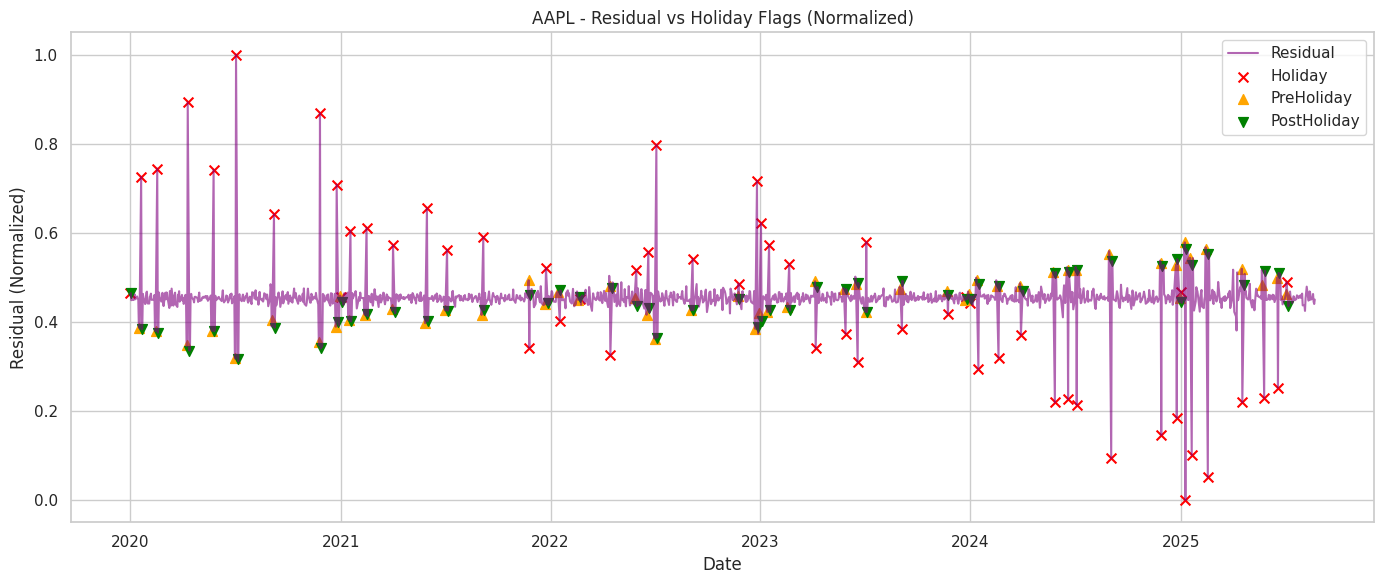

In [ ]:
import matplotlib.pyplot as plt

# เลือกหุ้นตัวอย่าง
example_symbol = final_df_norm['Symbol'].iloc[0]
example_df = final_df_norm[final_df_norm['Symbol']==example_symbol].set_index('Date')

plt.figure(figsize=(14,6))

# Plot Residual
plt.plot(example_df.index, example_df['Residual'], label='Residual', color='purple', alpha=0.6)

# Highlight Holiday
plt.scatter(example_df.index[example_df['Holiday']==1],
            example_df['Residual'][example_df['Holiday']==1],
            color='red', label='Holiday', marker='x', s=50)

# Highlight PreHoliday
plt.scatter(example_df.index[example_df['PreHoliday']==1],
            example_df['Residual'][example_df['PreHoliday']==1],
            color='orange', label='PreHoliday', marker='^', s=50)

# Highlight PostHoliday
plt.scatter(example_df.index[example_df['PostHoliday']==1],
            example_df['Residual'][example_df['PostHoliday']==1],
            color='green', label='PostHoliday', marker='v', s=50)

plt.title(f"{example_symbol} - Residual vs Holiday Flags (Normalized)")
plt.xlabel("Date")
plt.ylabel("Residual (Normalized)")
plt.legend()
plt.tight_layout()
plt.show()


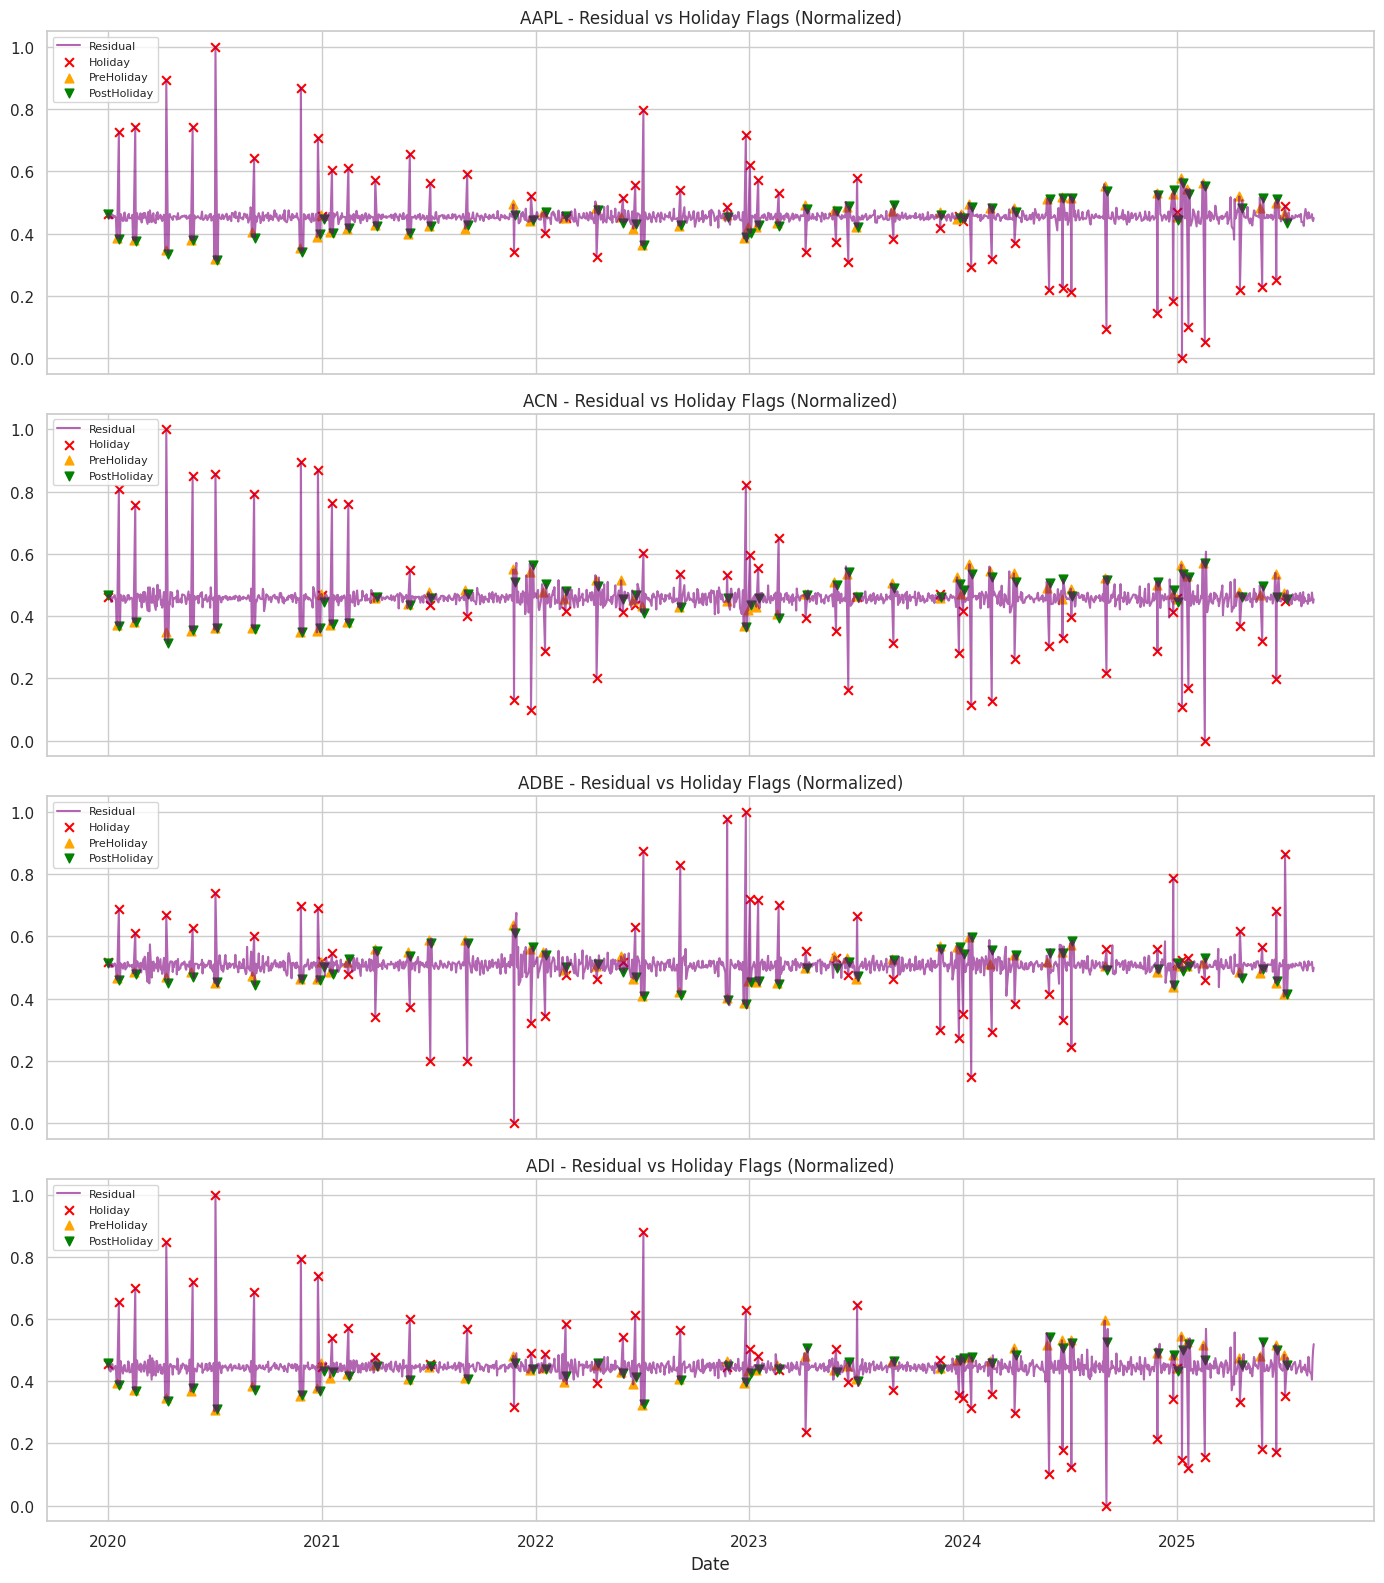

In [ ]:
import matplotlib.pyplot as plt

# เลือกจำนวนหุ้นที่จะ plot (ตัวอย่าง 4 หุ้นแรก)
symbols_to_plot = final_df_norm['Symbol'].unique()[:4]

fig, axes = plt.subplots(len(symbols_to_plot), 1, figsize=(14, 4*len(symbols_to_plot)), sharex=True)

for i, symbol in enumerate(symbols_to_plot):
    df_stock = final_df_norm[final_df_norm['Symbol']==symbol].set_index('Date')

    ax = axes[i]
    # Residual line
    ax.plot(df_stock.index, df_stock['Residual'], label='Residual', color='purple', alpha=0.6)

    # Holiday flags
    ax.scatter(df_stock.index[df_stock['Holiday']==1],
               df_stock['Residual'][df_stock['Holiday']==1],
               color='red', label='Holiday', marker='x', s=40)

    ax.scatter(df_stock.index[df_stock['PreHoliday']==1],
               df_stock['Residual'][df_stock['PreHoliday']==1],
               color='orange', label='PreHoliday', marker='^', s=40)

    ax.scatter(df_stock.index[df_stock['PostHoliday']==1],
               df_stock['Residual'][df_stock['PostHoliday']==1],
               color='green', label='PostHoliday', marker='v', s=40)

    ax.set_title(f"{symbol} - Residual vs Holiday Flags (Normalized)")
    ax.legend(loc='upper left', fontsize=8)

plt.xlabel("Date")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in 

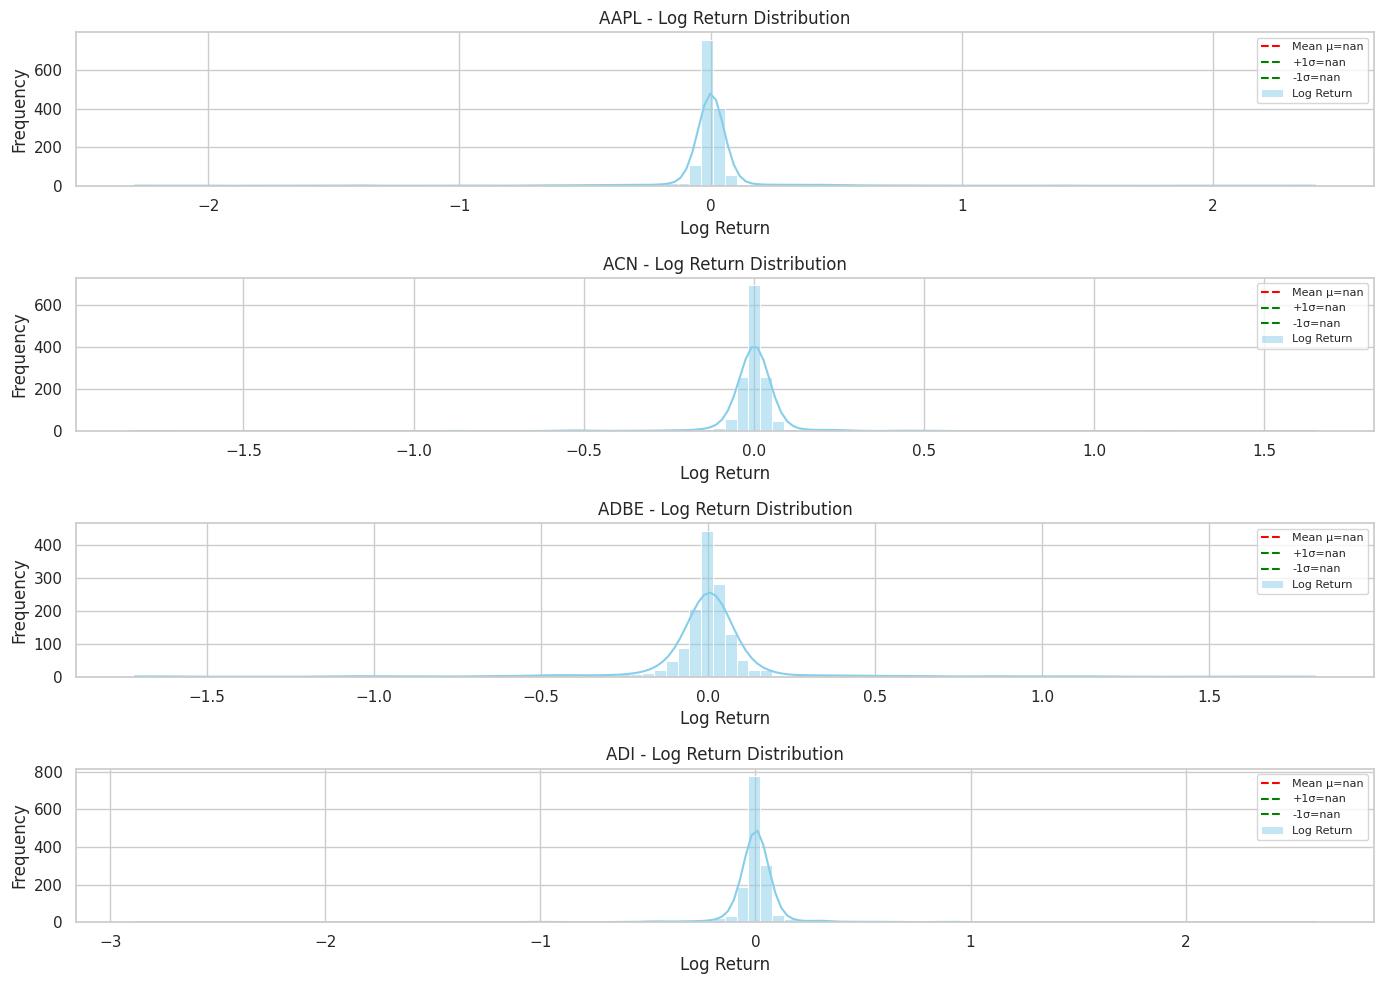

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# เลือกหุ้นตัวอย่าง 4 ตัวแรก
symbols_to_plot = final_df_norm['Symbol'].unique()[:4]

plt.figure(figsize=(14, 10))

for i, sym in enumerate(symbols_to_plot):
    df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')

    # คำนวณ log return
    df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))

    mu = df_stock['LogReturn'].mean()
    std = df_stock['LogReturn'].std()

    plt.subplot(len(symbols_to_plot), 1, i+1)

    # Histogram + KDE
    sns.histplot(df_stock['LogReturn'].dropna(), bins=100, kde=True, color='skyblue', label='Log Return')

    # Plot mean
    plt.axvline(mu, color='red', linestyle='--', label=f'Mean μ={mu:.4f}')

    # Plot ±1 std
    plt.axvline(mu + std, color='green', linestyle='--', label=f'+1σ={mu+std:.4f}')
    plt.axvline(mu - std, color='green', linestyle='--', label=f'-1σ={mu-std:.4f}')

    plt.title(f"{sym} - Log Return Distribution")
    plt.xlabel("Log Return")
    plt.ylabel("Frequency")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


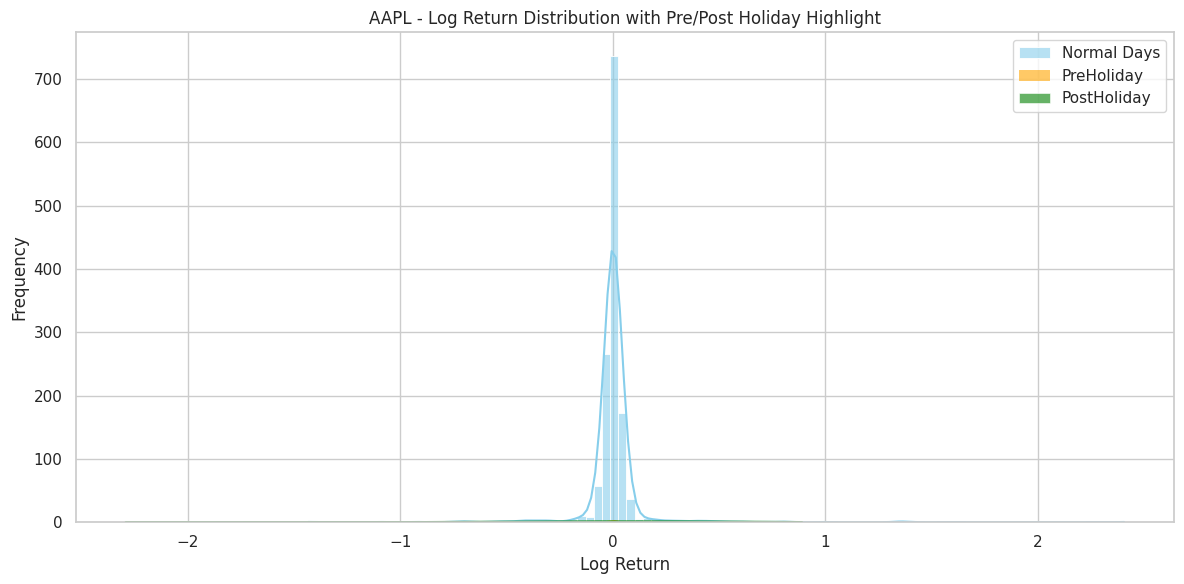

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# เลือกหุ้นตัวอย่าง 1 ตัว
sym = final_df_norm['Symbol'].iloc[0]
df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')

# คำนวณ Log Return
df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))

# แยกกลุ่มตาม holiday flags
pre_holiday = df_stock[df_stock['PreHoliday']==1]['LogReturn'].dropna()
post_holiday = df_stock[df_stock['PostHoliday']==1]['LogReturn'].dropna()
normal_days = df_stock[(df_stock['PreHoliday']==0) & (df_stock['PostHoliday']==0)]['LogReturn'].dropna()

plt.figure(figsize=(12,6))

# Histogram ของวันปกติ
sns.histplot(normal_days, bins=100, color='skyblue', label='Normal Days', kde=True, alpha=0.6)

# Overlay PreHoliday (orange)
sns.histplot(pre_holiday, bins=100, color='orange', label='PreHoliday', kde=True, alpha=0.6)

# Overlay PostHoliday (green)
sns.histplot(post_holiday, bins=100, color='green', label='PostHoliday', kde=True, alpha=0.6)

plt.title(f"{sym} - Log Return Distribution with Pre/Post Holiday Highlight")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# สร้าง DataFrame สรุปสำหรับหุ้นแต่ละตัว
summary_list = []

for sym in final_df_norm['Symbol'].unique():
    df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')

    # คำนวณ Log Return
    df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))

    # แยกกลุ่ม
    groups = {
        'Normal': df_stock[(df_stock['PreHoliday']==0) & (df_stock['PostHoliday']==0)]['LogReturn'].dropna(),
        'PreHoliday': df_stock[df_stock['PreHoliday']==1]['LogReturn'].dropna(),
        'PostHoliday': df_stock[df_stock['PostHoliday']==1]['LogReturn'].dropna()
    }

    for flag, data in groups.items():
        summary_list.append({
            'Symbol': sym,
            'DayType': flag,
            'Count': len(data),
            'Mean': data.mean(),
            'Std': data.std(),
            'Min': data.min(),
            '25%': data.quantile(0.25),
            '50%': data.quantile(0.5),
            '75%': data.quantile(0.75),
            'Max': data.max()
        })

# รวมเป็น DataFrame
logreturn_summary = pd.DataFrame(summary_list)

# แสดงตัวอย่าง
print(logreturn_summary.head(15))

# ถ้าต้องการ export เป็น Excel
logreturn_summary.to_excel("LogReturn_Holiday_Summary.xlsx", index=False)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:52: RuntimeWarning: invalid value encountered in 

   Symbol      DayType  Count      Mean       Std       Min       25%  \
0    AAPL       Normal   1363       NaN       NaN      -inf -0.014505   
1    AAPL   PreHoliday     54  0.004165  0.019039 -0.045425 -0.008200   
2    AAPL  PostHoliday     55 -0.123883  0.624445 -2.292327 -0.373534   
3     ACN       Normal   1363       NaN       NaN      -inf -0.017277   
4     ACN   PreHoliday     54  0.006886  0.035959 -0.038126 -0.011155   
5     ACN  PostHoliday     55 -0.046201  0.475798 -1.819434 -0.193925   
6    ADBE       Normal   1363       NaN       NaN      -inf -0.027963   
7    ADBE   PreHoliday     54  0.004220  0.051976 -0.149520 -0.017623   
8    ADBE  PostHoliday     55 -0.158310  0.619579 -1.685329 -0.538671   
9     ADI       Normal   1363       NaN       NaN      -inf -0.022298   
10    ADI   PreHoliday     54  0.003907  0.030078 -0.146356 -0.008640   
11    ADI  PostHoliday     55 -0.091260  0.545746 -1.840097 -0.320338   
12    ADM       Normal   1363       NaN       NaN  

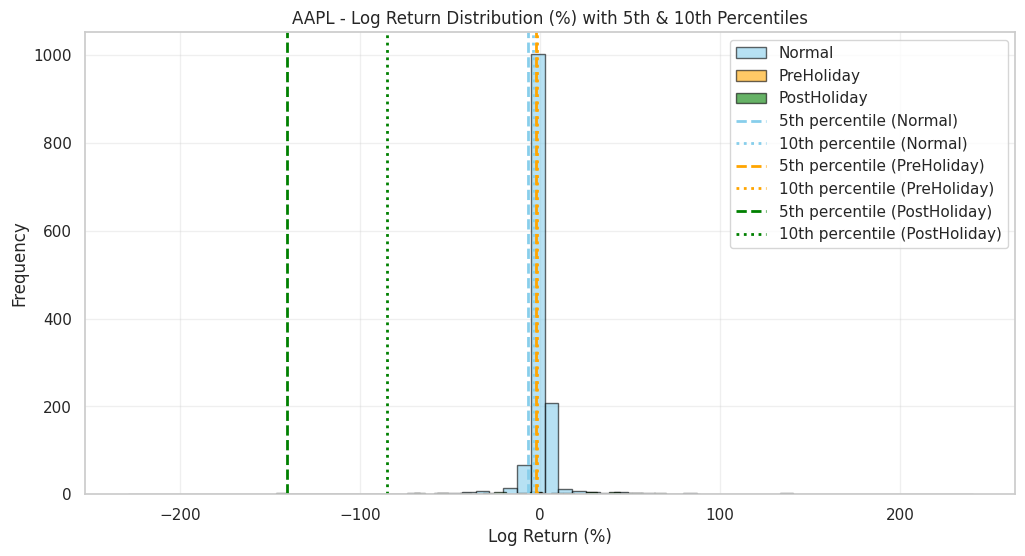

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# เลือกหุ้นตัวอย่าง
sym = 'AAPL'
df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')
df_stock = df_stock[df_stock['Close_filled'] > 0].copy()
df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))
df_stock.dropna(subset=['LogReturn'], inplace=True)

# แยกกลุ่ม
groups = {
    'Normal': df_stock[(df_stock['PreHoliday']==0) & (df_stock['PostHoliday']==0)]['LogReturn']*100,
    'PreHoliday': df_stock[df_stock['PreHoliday']==1]['LogReturn']*100,
    'PostHoliday': df_stock[df_stock['PostHoliday']==1]['LogReturn']*100
}

colors = {'Normal':'skyblue', 'PreHoliday':'orange', 'PostHoliday':'green'}

plt.figure(figsize=(12,6))

# Plot histogram แยกกันชัดเจน
for i, (key, data) in enumerate(groups.items()):
    plt.hist(data, bins=50, alpha=0.6, color=colors[key], label=key, edgecolor='black')

# คำนวณและ plot percentiles
for key, data in groups.items():
    p5 = np.percentile(data, 5)
    p10 = np.percentile(data, 10)
    plt.axvline(p5, color=colors[key], linestyle='--', linewidth=2, label=f'5th percentile ({key})')
    plt.axvline(p10, color=colors[key], linestyle=':', linewidth=2, label=f'10th percentile ({key})')

plt.title(f"{sym} - Log Return Distribution (%) with 5th & 10th Percentiles")
plt.xlabel("Log Return (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



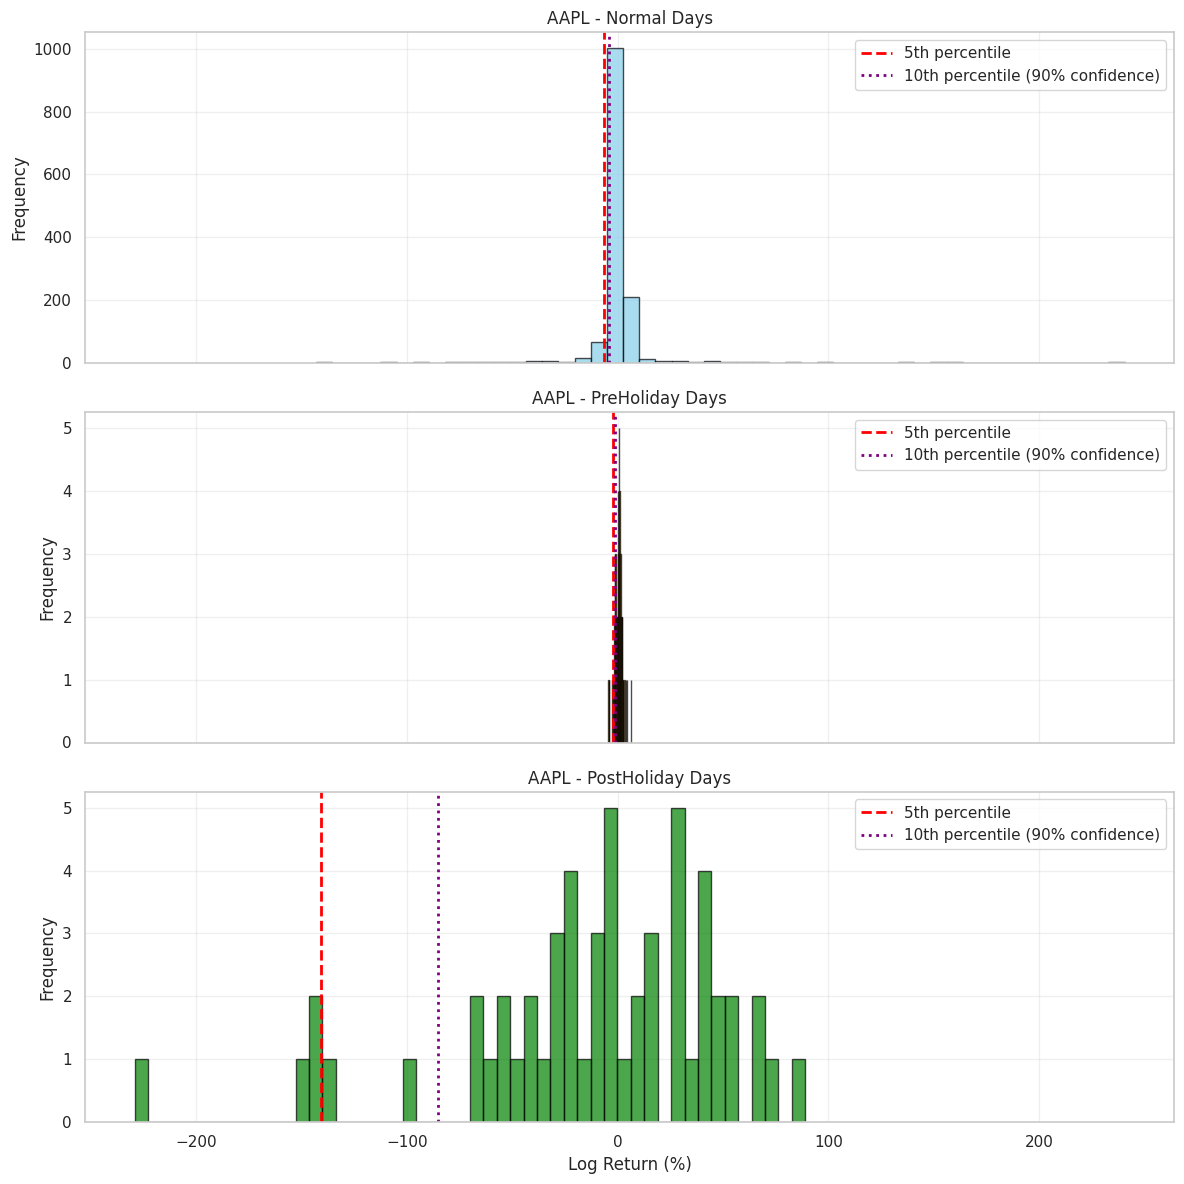

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# เลือกหุ้นตัวอย่าง
sym = 'AAPL'
df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')
df_stock = df_stock[df_stock['Close_filled'] > 0].copy()
df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))
df_stock.dropna(subset=['LogReturn'], inplace=True)

# แยกกลุ่ม
groups = {
    'Normal': df_stock[(df_stock['PreHoliday']==0) & (df_stock['PostHoliday']==0)]['LogReturn']*100,
    'PreHoliday': df_stock[df_stock['PreHoliday']==1]['LogReturn']*100,
    'PostHoliday': df_stock[df_stock['PostHoliday']==1]['LogReturn']*100
}

colors = {'Normal':'skyblue', 'PreHoliday':'orange', 'PostHoliday':'green'}

# สร้าง stacked subplots
fig, axes = plt.subplots(3, 1, figsize=(12,12), sharex=True)

for ax, (key, data) in zip(axes, groups.items()):
    ax.hist(data, bins=50, alpha=0.7, color=colors[key], edgecolor='black')

    # คำนวณ percentiles
    p5 = np.percentile(data, 5)
    p10 = np.percentile(data, 10)

    # วาดเส้น percentiles
    ax.axvline(p5, color='red', linestyle='--', linewidth=2, label='5th percentile')
    ax.axvline(p10, color='purple', linestyle=':', linewidth=2, label='10th percentile (90% confidence)')

    ax.set_title(f"{sym} - {key} Days")
    ax.set_ylabel("Frequency")
    ax.grid(True, alpha=0.3)
    ax.legend()

axes[-1].set_xlabel("Log Return (%)")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# สร้าง list เก็บผลลัพธ์
percentile_list = []

# loop ทุกหุ้น
for sym in final_df_norm['Symbol'].unique():
    df_stock = final_df_norm[final_df_norm['Symbol']==sym].sort_values('Date')
    df_stock = df_stock[df_stock['Close_filled'] > 0].copy()
    df_stock['LogReturn'] = np.log(df_stock['Close_filled'] / df_stock['Close_filled'].shift(1))
    df_stock.dropna(subset=['LogReturn'], inplace=True)

    # แยกกลุ่ม
    groups = {
        'Normal': df_stock[(df_stock['PreHoliday']==0) & (df_stock['PostHoliday']==0)]['LogReturn']*100,
        'PreHoliday': df_stock[df_stock['PreHoliday']==1]['LogReturn']*100,
        'PostHoliday': df_stock[df_stock['PostHoliday']==1]['LogReturn']*100
    }

    # คำนวณ percentiles
    for daytype, data in groups.items():
        if len(data) > 0:
            p5 = np.percentile(data, 5)
            p10 = np.percentile(data, 10)
        else:
            p5, p10 = np.nan, np.nan

        percentile_list.append({
            'Symbol': sym,
            'DayType': daytype,
            'Count': len(data),
            '5th Percentile (%)': p5,
            '10th Percentile (%)': p10
        })

# สร้าง DataFrame
percentile_df = pd.DataFrame(percentile_list)

# export เป็น Excel
percentile_df.to_excel("Stock_LogReturn_Percentiles.xlsx", index=False)

percentile_df.head(15)


,Symbol,DayType,Count,5th Percentile (%),10th Percentile (%)
0,AAPL,Normal,1362,-6.618487,-4.109706
1,AAPL,PreHoliday,54,-2.231212,-1.456177
2,AAPL,PostHoliday,55,-140.608929,-85.223100
3,ACN,Normal,1362,-8.050765,-4.480692
4,ACN,PreHoliday,54,-3.252162,-3.029397
5,ACN,PostHoliday,55,-88.716698,-72.129917
6,ADBE,Normal,1362,-15.614182,-8.775401
7,ADBE,PreHoliday,54,-7.874015,-4.890517
8,ADBE,PostHoliday,55,-107.722815,-105.681543
9,ADI,Normal,1362,-9.548181,-5.479033
